<a href="https://colab.research.google.com/github/acse-2020/acse2020-acse9-finalreport-acse-jaq15/blob/main/notebooks/LSTM/LSTM_EURCHF.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Imports

The cells below handle all the necessary imports to run our models, making use of the public repo feeder_repo, linked <!-- [Text](link) -->
[here](https://github.com/acse-jaq15/feeder_repo).

In [1]:
# clone the feeder repo to get data_reader module and financial time series data
!git clone https://github.com/acse-jaq15/feeder_repo.git

Cloning into 'feeder_repo'...
remote: Enumerating objects: 144, done.
remote: Counting objects: 100% (144/144), done.
remote: Compressing objects: 100% (139/139), done.
remote: Total 144 (delta 69), reused 6 (delta 2), pack-reused 0
Receiving objects: 100% (144/144), 119.43 KiB | 4.12 MiB/s, done.
Resolving deltas: 100% (69/69), done.


In [2]:
# using '%' to enforce a permanent change of directory
%cd feeder_repo/

/content/feeder_repo


In [3]:
# checking contents listed correctly, should read:
# baseline_model.py data data_reader.py LICENSE README.md security_plotter.py
!ls

base_model.py  data  data_reader.py  LICENSE  README.md  security_plotter.py


In [4]:
import math
import sys
import keras
import os
import matplotlib.dates as mdates
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from keras.layers import GRU
from keras.layers import Dropout
from keras.layers import *
from keras.utils.layer_utils import count_params
from keras.utils.vis_utils import plot_model
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
from sklearn.model_selection import train_test_split
from keras.callbacks import EarlyStopping, Callback
from keras.optimizers import RMSprop, SGD, Adam, Nadam
from keras.initializers import random_normal

In [5]:
# appending path with 'feeder_repo' string
sys.path.append('feeder_repo')

# import Data_Reader class from data_reader module
from feeder_repo.data_reader import Data_Reader
# import Baseline_Model class from base_model module
from feeder_repo.base_model import Base_Model
# import Security_Plotter class from security_plotter module
from feeder_repo.security_plotter import Security_Plotter

In [6]:
# checking if the notebook is running on a GPU
gpu_info = !nvidia-smi
gpu_info = '\n'.join(gpu_info)
if gpu_info.find('failed') >= 0:
    print('Select the Runtime > "Change runtime type" menu to enable a GPU accelerator, ')
    print('and then re-execute this cell.')
else:
    print(gpu_info)

Wed Jul 14 11:53:39 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 470.42.01    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla P100-PCIE...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   38C    P0    28W / 250W |      0MiB / 16280MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

# Handling the data
Here the Data_Reader class is used to read the time series data and extract training, test and validation sets, along with the relevant X and y values.

In [7]:
# storing the file to be read as a string
in_str = 'EURCHF'
# storing the year of the time series to be used as test data
in_yr = 2019
# creating a variable to store the model name
model_str = 'LSTM'
# setting our window_length to be 30 days
window_len = 30

In [8]:
# creating an instance of Data_Reader class
in_data = Data_Reader(in_str, in_yr)
# calling class method extract_train_test to generate training and test datasets
in_data.extract_train_test()
# calling class method extract_xy to generate X and y training and test datasets
in_data.extract_xy(window_len)

# assigning X_train and y_train
X_train = in_data.X_train
y_train = in_data.y_train

# assigning X_test and y_test
X_test = in_data.X_test
y_test = in_data.y_test

# assigning X_val_train and y_val_train
X_val_train = in_data.X_val_train
y_val_train = in_data.y_val_train

# assigning X_val_test and y_val_test
X_val_test = in_data.X_val_test
y_val_test = in_data.y_val_test

# Setting up wandb itegration
Here wandb is used to perform hyperparameter tuning.

In [9]:
# installing the wandb library and importing
%pip install wandb -q
import wandb
from wandb.keras import WandbCallback

     |████████████████████████████████| 1.8MB 6.4MB/s 
     |████████████████████████████████| 143kB 56.0MB/s 
     |████████████████████████████████| 174kB 56.4MB/s 
     |████████████████████████████████| 102kB 15.3MB/s 
     |████████████████████████████████| 71kB 11.7MB/s 


In [10]:
!pip install wandb -qq

In [11]:
# logging in so the hyperparameter tunings sweeps can be saved
!wandb login

wandb: You can find your API key in your browser here: https://wandb.ai/authorize
wandb: Paste an API key from your profile and hit enter: 
wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc


In [12]:
# configuring the sweep, making use of a random search methodology
sweep_config = {
    'method': 'random', #grid, random
    'metric': {
      'name': 'mse',
      'goal': 'minimize'   
    },
    'parameters': {
        'epochs': {
            'values': [50, 100, 200]
        },
        'batch_size': {
            'values': [128, 64, 32]
        },
        'dropout': {
            'values': [0.2, 0.3, 0.4]
        },
        'input_size': {
            'values': [25, 50, 100]
        },
        'hidden_size': {
            'values': [25, 50, 100]
        },
        'learning_rate': {
            'values': [0.005, 0.001, 0.0005]
        },
        'optimizer': {
            'values': ['adam', 'nadam', 'rmsprop']
        },
        'activation': {
            'values': ['tanh']
        }
    }
}

In [13]:
# The sweep calls this function with each set of hyperparameters
def train():
    # Default values for hyper-parameters we're going to sweep over
    config_defaults = {
        'epochs': 100,
        'batch_size': 32,
        'dropout': 0.2,
        'input_size': 50,
        'hidden_size': 50,
        'learning_rate': 0.005,
        'optimizer': 'adam',
        'activation': 'tanh',
        'momentum': 0.9,
        'seed': 42
    }

    # Initialize a new wandb run
    wandb.init(config=config_defaults)
    
    # Config is a variable that holds and saves hyperparameters and inputs
    config = wandb.config
    
    # Define the model architecture
    model = Sequential()

    # input layer
    model.add(LSTM(units=config.input_size, return_sequences=True, input_shape=(window_len, 1), activation=config.activation))
    model.add(Dropout(config.dropout))
    # second model layer with dropout
    model.add(LSTM(units=config.hidden_size, return_sequences=True, activation=config.activation))
    model.add(Dropout(config.dropout))
    # third model layer with dropout
    model.add(LSTM(units=config.hidden_size, return_sequences=True, activation=config.activation))
    model.add(Dropout(config.dropout))
    # fourth model layer with dropout
    model.add(LSTM(units=config.hidden_size, activation=config.activation))
    model.add(Dropout(config.dropout))
    # final layer with one output
    model.add(Dense(units=1))

    # Define the optimizer
    if config.optimizer=='sgd':
      optimizer = SGD(learning_rate=config.learning_rate, decay=1e-5, momentum=config.momentum, nesterov=True)
    elif config.optimizer=='rmsprop':
      optimizer = RMSprop(learning_rate=config.learning_rate, decay=1e-5)
    elif config.optimizer=='adam':
      optimizer = Adam(learning_rate=config.learning_rate, beta_1=0.9, beta_2=0.999, clipnorm=1.0)
    elif config.optimizer=='nadam':
      optimizer = Nadam(learning_rate=config.learning_rate, beta_1=0.9, beta_2=0.999, clipnorm=1.0)

    model.compile(loss = "mean_squared_error", optimizer=optimizer, metrics=['mean_squared_error', 'mean_absolute_error'])

    model.fit(X_val_train, y_val_train, batch_size=config.batch_size,
              epochs=config.epochs,
              validation_data=(X_val_test, y_val_test),
              callbacks=[WandbCallback(validation_data=(X_val_test, y_val_test)),
                          EarlyStopping(patience=10, restore_best_weights=True)])

In [14]:
# setting up our sweep_id
sweep_id = wandb.sweep(sweep_config, project='ACSE_9_'+model_str)

Create sweep with ID: i2jf8j9t
Sweep URL: https://wandb.ai/acse-jaq15/ACSE_9_LSTM/sweeps/i2jf8j9t


In [15]:
# initialising a new sweep
wandb.agent(sweep_id, train, project='ACSE_9_'+model_str)

wandb: Agent Starting Run: cuyc9016 with config:
wandb: 	activation: tanh
wandb: 	batch_size: 128
wandb: 	dropout: 0.3
wandb: 	epochs: 50
wandb: 	hidden_size: 25
wandb: 	input_size: 25
wandb: 	learning_rate: 0.005
wandb: 	optimizer: nadam
wandb: Currently logged in as: acse-jaq15 (use `wandb login --relogin` to force relogin)


Epoch 1/50
8/8 [==============================] - 25s 291ms/step - loss: 0.1602 - mean_squared_error: 0.1602 - mean_absolute_error: 0.3225 - val_loss: 0.0422 - val_mean_squared_error: 0.0422 - val_mean_absolute_error: 0.1768
Epoch 2/50
8/8 [==============================] - 0s 17ms/step - loss: 0.0244 - mean_squared_error: 0.0244 - mean_absolute_error: 0.1198 - val_loss: 0.0302 - val_mean_squared_error: 0.0302 - val_mean_absolute_error: 0.1462
Epoch 3/50
8/8 [==============================] - 0s 19ms/step - loss: 0.0352 - mean_squared_error: 0.0352 - mean_absolute_error: 0.1360 - val_loss: 0.0274 - val_mean_squared_error: 0.0274 - val_mean_absolute_error: 0.1393
Epoch 4/50
8/8 [==============================] - 0s 17ms/step - loss: 0.0212 - mean_squared_error: 0.0212 - mean_absolute_error: 0.1018 - val_loss: 0.0403 - val_mean_squared_error: 0.0403 - val_mean_absolute_error: 0.1546
Epoch 5/50
8/8 [==============================] - 0s 18ms/step - loss: 0.0332 - mean_squared_error: 0.0332

epoch,49
loss,0.00692
mean_squared_error,0.00692
mean_absolute_error,0.05209
val_loss,0.00937
val_mean_squared_error,0.00937
val_mean_absolute_error,0.07013
_runtime,42
_timestamp,1626263816
_step,49
best_val_loss,0.00897


epoch,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇███
loss,█▂▃▂▂▂▂▂▂▂▂▂▁▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
mean_squared_error,█▂▃▂▂▂▂▂▂▂▂▂▁▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
mean_absolute_error,█▃▄▃▃▃▂▃▂▃▂▂▂▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_loss,█▅▅█▆▄▄▆▄▄▄▃▄▃▃▃▃▃▃▃▃▃▂▂▂▂▂▂▁▂▂▁▁▁▁▁▁▁▂▁
val_mean_squared_error,█▅▅█▆▄▄▆▄▄▄▃▄▃▃▃▃▃▃▃▃▃▂▂▂▂▂▂▁▂▂▁▁▁▁▁▁▁▂▁
val_mean_absolute_error,█▆▆▇▆▅▅▆▄▄▄▄▄▄▄▃▄▃▃▃▃▃▂▃▂▂▂▂▂▂▂▂▁▁▁▁▁▁▂▁
_runtime,▁▁▁▂▂▂▂▂▃▃▃▃▃▃▃▃▄▄▄▄▅▅▅▅▅▆▆▆▆▆▆▆▆▆▇▇▇▇██
_timestamp,▁▁▁▂▂▂▂▂▃▃▃▃▃▃▃▃▄▄▄▄▅▅▅▅▅▆▆▆▆▆▆▆▆▆▇▇▇▇██
_step,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇███


wandb: Agent Starting Run: zqxpfg7i with config:
wandb: 	activation: tanh
wandb: 	batch_size: 64
wandb: 	dropout: 0.4
wandb: 	epochs: 100
wandb: 	hidden_size: 100
wandb: 	input_size: 50
wandb: 	learning_rate: 0.005
wandb: 	optimizer: nadam


Epoch 1/100
16/16 [==============================] - 9s 129ms/step - loss: 1.1354 - mean_squared_error: 1.1354 - mean_absolute_error: 0.5876 - val_loss: 0.0311 - val_mean_squared_error: 0.0311 - val_mean_absolute_error: 0.1411
Epoch 2/100
16/16 [==============================] - 0s 17ms/step - loss: 0.0349 - mean_squared_error: 0.0349 - mean_absolute_error: 0.1427 - val_loss: 0.0299 - val_mean_squared_error: 0.0299 - val_mean_absolute_error: 0.1370
Epoch 3/100
16/16 [==============================] - 0s 20ms/step - loss: 0.0224 - mean_squared_error: 0.0224 - mean_absolute_error: 0.1101 - val_loss: 0.0194 - val_mean_squared_error: 0.0194 - val_mean_absolute_error: 0.1107
Epoch 4/100
16/16 [==============================] - 0s 19ms/step - loss: 0.0251 - mean_squared_error: 0.0251 - mean_absolute_error: 0.1110 - val_loss: 0.0188 - val_mean_squared_error: 0.0188 - val_mean_absolute_error: 0.1093
Epoch 5/100
16/16 [==============================] - 0s 19ms/step - loss: 0.0128 - mean_squared

wandb: Processing terminal ouput (stdout)...
wandb: Done.


epoch,75
loss,0.00302
mean_squared_error,0.00302
mean_absolute_error,0.03484
val_loss,0.00432
val_mean_squared_error,0.00432
val_mean_absolute_error,0.04728
_runtime,37
_timestamp,1626263860
_step,75
best_val_loss,0.00339


epoch,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
loss,█▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
mean_squared_error,█▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
mean_absolute_error,█▃▃▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_loss,██▅▄▄▄▄▃▃▃▂▂▂▂▂▂▂▂▂▁▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▂▁
val_mean_squared_error,██▅▄▄▄▄▃▃▃▂▂▂▂▂▂▂▂▂▁▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▂▁
val_mean_absolute_error,██▆▅▄▅▅▃▅▄▂▃▂▃▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▂▁▁▂▁▁▁▁▂▁
_runtime,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇▇██
_timestamp,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇▇██
_step,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███


wandb: Agent Starting Run: nk1jafpp with config:
wandb: 	activation: tanh
wandb: 	batch_size: 64
wandb: 	dropout: 0.3
wandb: 	epochs: 50
wandb: 	hidden_size: 100
wandb: 	input_size: 100
wandb: 	learning_rate: 0.001
wandb: 	optimizer: rmsprop


Epoch 1/50
16/16 [==============================] - 8s 119ms/step - loss: 0.3926 - mean_squared_error: 0.3926 - mean_absolute_error: 0.4303 - val_loss: 0.0308 - val_mean_squared_error: 0.0308 - val_mean_absolute_error: 0.1488
Epoch 2/50
16/16 [==============================] - 0s 14ms/step - loss: 0.0122 - mean_squared_error: 0.0122 - mean_absolute_error: 0.0772 - val_loss: 0.0292 - val_mean_squared_error: 0.0292 - val_mean_absolute_error: 0.1440
Epoch 3/50
16/16 [==============================] - 0s 14ms/step - loss: 0.0136 - mean_squared_error: 0.0136 - mean_absolute_error: 0.0851 - val_loss: 0.0267 - val_mean_squared_error: 0.0267 - val_mean_absolute_error: 0.1365
Epoch 4/50
16/16 [==============================] - 0s 14ms/step - loss: 0.0206 - mean_squared_error: 0.0206 - mean_absolute_error: 0.1030 - val_loss: 0.0259 - val_mean_squared_error: 0.0259 - val_mean_absolute_error: 0.1347
Epoch 5/50
16/16 [==============================] - 0s 15ms/step - loss: 0.0189 - mean_squared_erro

epoch,49
loss,0.00448
mean_squared_error,0.00448
mean_absolute_error,0.04552
val_loss,0.00498
val_mean_squared_error,0.00498
val_mean_absolute_error,0.0554
_runtime,25
_timestamp,1626263904
_step,49
best_val_loss,0.00445


epoch,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇███
loss,█▁▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
mean_squared_error,█▁▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
mean_absolute_error,█▂▃▄▃▃▃▂▂▂▂▂▂▂▂▂▂▂▂▂▂▁▂▁▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_loss,██▇▇▆▇▆▆▆▅▅▃▃▃▄▂▂▄▂▂▂▃▂▃▂▁▄▁▁▁▂▁▂▂▁▁▁▁▁▁
val_mean_squared_error,██▇▇▆▇▆▆▆▅▅▃▃▃▄▂▂▄▂▂▂▃▂▃▂▁▄▁▁▁▂▁▂▂▁▁▁▁▁▁
val_mean_absolute_error,██▇▇▇▇▆▆▆▅▅▄▃▃▄▃▂▄▃▂▂▃▂▄▂▂▄▁▁▁▂▁▃▂▁▁▁▁▁▁
_runtime,▁▁▂▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▆▇▇▇▇▇▇█
_timestamp,▁▁▂▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▆▇▇▇▇▇▇█
_step,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇███


wandb: Agent Starting Run: zox83jfv with config:
wandb: 	activation: tanh
wandb: 	batch_size: 32
wandb: 	dropout: 0.3
wandb: 	epochs: 200
wandb: 	hidden_size: 50
wandb: 	input_size: 50
wandb: 	learning_rate: 0.005
wandb: 	optimizer: rmsprop


Epoch 1/200
32/32 [==============================] - 8s 68ms/step - loss: 0.2609 - mean_squared_error: 0.2609 - mean_absolute_error: 0.3832 - val_loss: 0.0313 - val_mean_squared_error: 0.0313 - val_mean_absolute_error: 0.1519
Epoch 2/200
32/32 [==============================] - 0s 13ms/step - loss: 0.0390 - mean_squared_error: 0.0390 - mean_absolute_error: 0.1529 - val_loss: 0.0320 - val_mean_squared_error: 0.0320 - val_mean_absolute_error: 0.1369
Epoch 3/200
32/32 [==============================] - 0s 14ms/step - loss: 0.0257 - mean_squared_error: 0.0257 - mean_absolute_error: 0.1256 - val_loss: 0.0159 - val_mean_squared_error: 0.0159 - val_mean_absolute_error: 0.0957
Epoch 4/200
32/32 [==============================] - 0s 13ms/step - loss: 0.0169 - mean_squared_error: 0.0169 - mean_absolute_error: 0.0943 - val_loss: 0.0273 - val_mean_squared_error: 0.0273 - val_mean_absolute_error: 0.1462
Epoch 5/200
32/32 [==============================] - 0s 14ms/step - loss: 0.0199 - mean_squared_

epoch,27
loss,0.00363
mean_squared_error,0.00363
mean_absolute_error,0.04123
val_loss,0.00437
val_mean_squared_error,0.00437
val_mean_absolute_error,0.05002
_runtime,25
_timestamp,1626263936
_step,27
best_val_loss,0.00423


epoch,▁▁▂▂▂▂▃▃▃▃▄▄▄▄▅▅▅▅▆▆▆▆▇▇▇▇██
loss,█▃▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
mean_squared_error,█▃▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
mean_absolute_error,█▅▄▃▃▂▂▂▂▂▂▂▁▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_loss,██▄▇▆▄▂▃▃▂▃▄▃▁▂▁▁▁▁▂▁▂▁▁▂▁▂▁
val_mean_squared_error,██▄▇▆▄▂▃▃▂▃▄▃▁▂▁▁▁▁▂▁▂▁▁▂▁▂▁
val_mean_absolute_error,█▇▄█▆▄▃▄▃▃▄▄▄▂▂▁▁▁▁▂▁▃▂▁▂▁▁▁
_runtime,▁▂▂▂▂▃▃▃▃▃▄▄▄▄▅▅▅▅▆▆▆▆▆▇▇▇▇█
_timestamp,▁▂▂▂▂▃▃▃▃▃▄▄▄▄▅▅▅▅▆▆▆▆▆▇▇▇▇█
_step,▁▁▂▂▂▂▃▃▃▃▄▄▄▄▅▅▅▅▆▆▆▆▇▇▇▇██


wandb: Agent Starting Run: la1ordiu with config:
wandb: 	activation: tanh
wandb: 	batch_size: 128
wandb: 	dropout: 0.2
wandb: 	epochs: 50
wandb: 	hidden_size: 100
wandb: 	input_size: 25
wandb: 	learning_rate: 0.001
wandb: 	optimizer: rmsprop


Epoch 1/50
8/8 [==============================] - 8s 243ms/step - loss: 0.2502 - mean_squared_error: 0.2502 - mean_absolute_error: 0.4345 - val_loss: 0.0376 - val_mean_squared_error: 0.0376 - val_mean_absolute_error: 0.1671
Epoch 2/50
8/8 [==============================] - 0s 17ms/step - loss: 0.0125 - mean_squared_error: 0.0125 - mean_absolute_error: 0.0824 - val_loss: 0.0303 - val_mean_squared_error: 0.0303 - val_mean_absolute_error: 0.1476
Epoch 3/50
8/8 [==============================] - 0s 18ms/step - loss: 0.0158 - mean_squared_error: 0.0158 - mean_absolute_error: 0.0901 - val_loss: 0.0329 - val_mean_squared_error: 0.0329 - val_mean_absolute_error: 0.1525
Epoch 4/50
8/8 [==============================] - 0s 16ms/step - loss: 0.0179 - mean_squared_error: 0.0179 - mean_absolute_error: 0.0909 - val_loss: 0.0323 - val_mean_squared_error: 0.0323 - val_mean_absolute_error: 0.1500
Epoch 5/50
8/8 [==============================] - 0s 17ms/step - loss: 0.0161 - mean_squared_error: 0.0161 

epoch,49
loss,0.00796
mean_squared_error,0.00796
mean_absolute_error,0.06087
val_loss,0.00828
val_mean_squared_error,0.00828
val_mean_absolute_error,0.06822
_runtime,19
_timestamp,1626263962
_step,49
best_val_loss,0.00828


epoch,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇███
loss,█▁▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
mean_squared_error,█▁▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
mean_absolute_error,█▂▂▂▃▂▃▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▁▂▁▂▂▁▂▁▂▁▂▁▁▁▂▁
val_loss,█▆▇▇█▅▅█▅▇▅▅▆▅▄▄▆▆▄▃▃▄▃▃▂▂▄▃▃▂▂▃▃▂▂▃▁▁▁▁
val_mean_squared_error,█▆▇▇█▅▅█▅▇▅▅▆▅▄▄▆▆▄▃▃▄▃▃▂▂▄▃▃▂▂▃▃▂▂▃▁▁▁▁
val_mean_absolute_error,█▇▇▇▇▅▅▇▆▇▅▅▅▅▄▄▅▆▄▃▃▄▃▃▂▃▄▃▃▂▂▃▃▂▂▃▁▁▂▁
_runtime,▁▁▁▁▁▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇████
_timestamp,▁▁▁▁▁▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇████
_step,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇███


wandb: Agent Starting Run: 0r5q102d with config:
wandb: 	activation: tanh
wandb: 	batch_size: 128
wandb: 	dropout: 0.2
wandb: 	epochs: 200
wandb: 	hidden_size: 50
wandb: 	input_size: 50
wandb: 	learning_rate: 0.005
wandb: 	optimizer: rmsprop


Epoch 1/200
8/8 [==============================] - 8s 235ms/step - loss: 1.2803 - mean_squared_error: 1.2803 - mean_absolute_error: 0.8188 - val_loss: 0.0425 - val_mean_squared_error: 0.0425 - val_mean_absolute_error: 0.1615
Epoch 2/200
8/8 [==============================] - 0s 15ms/step - loss: 0.0447 - mean_squared_error: 0.0447 - mean_absolute_error: 0.1632 - val_loss: 0.0480 - val_mean_squared_error: 0.0480 - val_mean_absolute_error: 0.1679
Epoch 3/200
8/8 [==============================] - 0s 16ms/step - loss: 0.0511 - mean_squared_error: 0.0511 - mean_absolute_error: 0.1812 - val_loss: 0.0729 - val_mean_squared_error: 0.0729 - val_mean_absolute_error: 0.2057
Epoch 4/200
8/8 [==============================] - 0s 17ms/step - loss: 0.0604 - mean_squared_error: 0.0604 - mean_absolute_error: 0.1948 - val_loss: 0.0306 - val_mean_squared_error: 0.0306 - val_mean_absolute_error: 0.1399
Epoch 5/200
8/8 [==============================] - 0s 16ms/step - loss: 0.0456 - mean_squared_error: 0.

epoch,52
loss,0.00401
mean_squared_error,0.00401
mean_absolute_error,0.04661
val_loss,0.00848
val_mean_squared_error,0.00848
val_mean_absolute_error,0.06348
_runtime,20
_timestamp,1626263990
_step,52
best_val_loss,0.00584


epoch,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
loss,█▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
mean_squared_error,█▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
mean_absolute_error,█▃▃▃▂▃▃▂▂▃▂▂▂▂▁▂▁▁▁▁▁▁▁▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_loss,▅▅█▄▃▄▃▆▂▃▄▂▅▂▂▂▂▄▁▂▂▂▁▁▁▁▃▁▂▂▁▁▁▁▁▂▁▂▁▁
val_mean_squared_error,▅▅█▄▃▄▃▆▂▃▄▂▅▂▂▂▂▄▁▂▂▂▁▁▁▁▃▁▂▂▁▁▁▁▁▂▁▂▁▁
val_mean_absolute_error,▆▆█▆▅▅▅▆▃▄▅▃▆▃▃▃▂▆▂▃▄▃▂▂▂▁▄▂▂▂▂▂▁▁▂▂▁▃▁▁
_runtime,▁▁▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇███
_timestamp,▁▁▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇███
_step,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███


wandb: Agent Starting Run: o71mf14n with config:
wandb: 	activation: tanh
wandb: 	batch_size: 64
wandb: 	dropout: 0.4
wandb: 	epochs: 200
wandb: 	hidden_size: 25
wandb: 	input_size: 25
wandb: 	learning_rate: 0.0005
wandb: 	optimizer: rmsprop


Epoch 1/200
16/16 [==============================] - 8s 123ms/step - loss: 0.1938 - mean_squared_error: 0.1938 - mean_absolute_error: 0.3769 - val_loss: 0.0354 - val_mean_squared_error: 0.0354 - val_mean_absolute_error: 0.1623
Epoch 2/200
16/16 [==============================] - 0s 18ms/step - loss: 0.0358 - mean_squared_error: 0.0358 - mean_absolute_error: 0.1418 - val_loss: 0.0316 - val_mean_squared_error: 0.0316 - val_mean_absolute_error: 0.1435
Epoch 3/200
16/16 [==============================] - 0s 14ms/step - loss: 0.0263 - mean_squared_error: 0.0263 - mean_absolute_error: 0.1224 - val_loss: 0.0295 - val_mean_squared_error: 0.0295 - val_mean_absolute_error: 0.1431
Epoch 4/200
16/16 [==============================] - 0s 14ms/step - loss: 0.0246 - mean_squared_error: 0.0246 - mean_absolute_error: 0.1149 - val_loss: 0.0329 - val_mean_squared_error: 0.0329 - val_mean_absolute_error: 0.1493
Epoch 5/200
16/16 [==============================] - 0s 14ms/step - loss: 0.0237 - mean_squared

epoch,192
loss,0.00407
mean_squared_error,0.00407
mean_absolute_error,0.03992
val_loss,0.00582
val_mean_squared_error,0.00582
val_mean_absolute_error,0.0576
_runtime,62
_timestamp,1626264060
_step,192
best_val_loss,0.00537


epoch,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
loss,█▆▅▄▄▄▃▃▃▃▃▃▃▃▂▂▂▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁
mean_squared_error,█▆▅▄▄▄▃▃▃▃▃▃▃▃▂▂▂▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁
mean_absolute_error,█▆▆▅▅▄▄▄▄▄▃▃▃▃▃▃▂▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_loss,██▇▇█▇▆▅▅▅▄▄▄▃▃▃▃▃▃▂▂▂▂▂▂▂▂▂▁▁▁▂▁▁▁▁▁▁▁▁
val_mean_squared_error,██▇▇█▇▆▅▅▅▄▄▄▃▃▃▃▃▃▂▂▂▂▂▂▂▂▂▁▁▁▂▁▁▁▁▁▁▁▁
val_mean_absolute_error,██▇█▇▇▇▆▆▅▅▅▄▄▄▃▃▄▃▃▃▃▂▂▂▂▂▂▂▂▂▂▂▁▁▁▂▁▁▁
_runtime,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇████
_timestamp,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇████
_step,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███


wandb: Agent Starting Run: qj6fwpsa with config:
wandb: 	activation: tanh
wandb: 	batch_size: 64
wandb: 	dropout: 0.2
wandb: 	epochs: 100
wandb: 	hidden_size: 25
wandb: 	input_size: 25
wandb: 	learning_rate: 0.005
wandb: 	optimizer: rmsprop


Epoch 1/100
16/16 [==============================] - 8s 118ms/step - loss: 0.2076 - mean_squared_error: 0.2076 - mean_absolute_error: 0.3699 - val_loss: 0.1145 - val_mean_squared_error: 0.1145 - val_mean_absolute_error: 0.2971
Epoch 2/100
16/16 [==============================] - 0s 14ms/step - loss: 0.0557 - mean_squared_error: 0.0557 - mean_absolute_error: 0.1847 - val_loss: 0.0295 - val_mean_squared_error: 0.0295 - val_mean_absolute_error: 0.1330
Epoch 3/100
16/16 [==============================] - 0s 15ms/step - loss: 0.0329 - mean_squared_error: 0.0329 - mean_absolute_error: 0.1414 - val_loss: 0.0386 - val_mean_squared_error: 0.0386 - val_mean_absolute_error: 0.1610
Epoch 4/100
16/16 [==============================] - 0s 15ms/step - loss: 0.0273 - mean_squared_error: 0.0273 - mean_absolute_error: 0.1291 - val_loss: 0.0334 - val_mean_squared_error: 0.0334 - val_mean_absolute_error: 0.1383
Epoch 5/100
16/16 [==============================] - 0s 15ms/step - loss: 0.0248 - mean_squared

epoch,31
loss,0.00416
mean_squared_error,0.00416
mean_absolute_error,0.04575
val_loss,0.01034
val_mean_squared_error,0.01034
val_mean_absolute_error,0.08218
_runtime,20
_timestamp,1626264089
_step,31
best_val_loss,0.00512


epoch,▁▁▁▂▂▂▂▃▃▃▃▃▄▄▄▄▅▅▅▅▆▆▆▆▆▇▇▇▇███
loss,█▃▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
mean_squared_error,█▃▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
mean_absolute_error,█▅▄▄▃▃▃▂▂▂▂▂▂▂▂▂▂▂▁▂▁▁▁▁▁▁▁▁▁▁▁▁
val_loss,█▃▃▃▂▃▂▂▂▁▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▂▁▂▁▁
val_mean_squared_error,█▃▃▃▂▃▂▂▂▁▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▂▁▂▁▁
val_mean_absolute_error,█▃▄▃▃▄▃▂▃▂▂▂▂▂▂▂▂▁▁▂▁▁▁▁▂▁▁▂▂▂▁▂
_runtime,▁▂▂▂▂▃▃▃▃▄▄▄▄▅▅▅▅▅▅▅▅▆▆▆▆▇▇▇▇███
_timestamp,▁▂▂▂▂▃▃▃▃▄▄▄▄▅▅▅▅▅▅▅▅▆▆▆▆▇▇▇▇███
_step,▁▁▁▂▂▂▂▃▃▃▃▃▄▄▄▄▅▅▅▅▆▆▆▆▆▇▇▇▇███


wandb: Agent Starting Run: 1t5yy2pd with config:
wandb: 	activation: tanh
wandb: 	batch_size: 32
wandb: 	dropout: 0.2
wandb: 	epochs: 100
wandb: 	hidden_size: 100
wandb: 	input_size: 50
wandb: 	learning_rate: 0.0005
wandb: 	optimizer: nadam


Epoch 1/100
32/32 [==============================] - 9s 66ms/step - loss: 0.1161 - mean_squared_error: 0.1161 - mean_absolute_error: 0.2413 - val_loss: 0.0281 - val_mean_squared_error: 0.0281 - val_mean_absolute_error: 0.1392
Epoch 2/100
32/32 [==============================] - 1s 17ms/step - loss: 0.0152 - mean_squared_error: 0.0152 - mean_absolute_error: 0.0774 - val_loss: 0.0377 - val_mean_squared_error: 0.0377 - val_mean_absolute_error: 0.1535
Epoch 3/100
32/32 [==============================] - 1s 17ms/step - loss: 0.0142 - mean_squared_error: 0.0142 - mean_absolute_error: 0.0760 - val_loss: 0.0295 - val_mean_squared_error: 0.0295 - val_mean_absolute_error: 0.1387
Epoch 4/100
32/32 [==============================] - 1s 17ms/step - loss: 0.0109 - mean_squared_error: 0.0109 - mean_absolute_error: 0.0647 - val_loss: 0.0250 - val_mean_squared_error: 0.0250 - val_mean_absolute_error: 0.1295
Epoch 5/100
32/32 [==============================] - 1s 16ms/step - loss: 0.0084 - mean_squared_

epoch,99
loss,0.00241
mean_squared_error,0.00241
mean_absolute_error,0.02801
val_loss,0.0042
val_mean_squared_error,0.0042
val_mean_absolute_error,0.05001
_runtime,74
_timestamp,1626264171
_step,99
best_val_loss,0.004


epoch,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
loss,█▂▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
mean_squared_error,█▂▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
mean_absolute_error,█▄▃▃▃▃▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_loss,██▆▆▅▄▃▃▃▃▂▂▂▂▂▂▂▃▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_mean_squared_error,██▆▆▅▄▃▃▃▃▂▂▂▂▂▂▂▃▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_mean_absolute_error,██▆▆▆▅▄▄▃▃▃▃▂▂▂▂▂▃▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
_runtime,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇▇███
_timestamp,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇▇███
_step,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███


wandb: Agent Starting Run: 16k4mpai with config:
wandb: 	activation: tanh
wandb: 	batch_size: 64
wandb: 	dropout: 0.4
wandb: 	epochs: 100
wandb: 	hidden_size: 25
wandb: 	input_size: 100
wandb: 	learning_rate: 0.005
wandb: 	optimizer: rmsprop


Epoch 1/100
16/16 [==============================] - 9s 125ms/step - loss: 0.2153 - mean_squared_error: 0.2153 - mean_absolute_error: 0.3754 - val_loss: 0.0732 - val_mean_squared_error: 0.0732 - val_mean_absolute_error: 0.2068
Epoch 2/100
16/16 [==============================] - 0s 15ms/step - loss: 0.0564 - mean_squared_error: 0.0564 - mean_absolute_error: 0.1860 - val_loss: 0.0271 - val_mean_squared_error: 0.0271 - val_mean_absolute_error: 0.1390
Epoch 3/100
16/16 [==============================] - 0s 16ms/step - loss: 0.0348 - mean_squared_error: 0.0348 - mean_absolute_error: 0.1321 - val_loss: 0.0237 - val_mean_squared_error: 0.0237 - val_mean_absolute_error: 0.1287
Epoch 4/100
16/16 [==============================] - 0s 15ms/step - loss: 0.0302 - mean_squared_error: 0.0302 - mean_absolute_error: 0.1297 - val_loss: 0.0243 - val_mean_squared_error: 0.0243 - val_mean_absolute_error: 0.1308
Epoch 5/100
16/16 [==============================] - 0s 15ms/step - loss: 0.0227 - mean_squared

epoch,40
loss,0.00552
mean_squared_error,0.00552
mean_absolute_error,0.05159
val_loss,0.00549
val_mean_squared_error,0.00549
val_mean_absolute_error,0.05372
_runtime,24
_timestamp,1626264203
_step,40
best_val_loss,0.00498


epoch,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇▇██
loss,█▄▄▂▂▃▂▂▂▂▂▂▂▂▂▁▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
mean_squared_error,█▄▄▂▂▃▂▂▂▂▂▂▂▂▂▁▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
mean_absolute_error,█▅▅▄▄▄▃▃▃▃▃▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▁▁▂▁▁▁▁▁▁▁▁▁▁▁
val_loss,█▃▃▃▃▃▃▂▂▃▂▃▂▃▂▁▂▂▂▂▁▂▂▁▂▁▂▂▂▁▁▂▁▁▁▁▁▁▁▁
val_mean_squared_error,█▃▃▃▃▃▃▂▂▃▂▃▂▃▂▁▂▂▂▂▁▂▂▁▂▁▂▂▂▁▁▂▁▁▁▁▁▁▁▁
val_mean_absolute_error,█▅▅▅▄▄▄▄▄▄▃▅▃▄▂▂▃▃▃▃▁▃▂▁▂▂▃▃▂▂▁▂▂▂▂▁▂▂▁▁
_runtime,▁▁▁▂▂▂▂▂▂▂▂▃▃▃▄▄▄▄▅▅▅▅▅▅▅▆▆▆▆▇▇▇▇▇▇▇▇███
_timestamp,▁▁▁▂▂▂▂▂▂▂▂▃▃▃▄▄▄▄▅▅▅▅▅▅▅▆▆▆▆▇▇▇▇▇▇▇▇███
_step,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇▇██


wandb: Agent Starting Run: qdbmj3k6 with config:
wandb: 	activation: tanh
wandb: 	batch_size: 64
wandb: 	dropout: 0.4
wandb: 	epochs: 100
wandb: 	hidden_size: 100
wandb: 	input_size: 50
wandb: 	learning_rate: 0.005
wandb: 	optimizer: nadam


Epoch 1/100
16/16 [==============================] - 9s 128ms/step - loss: 0.2034 - mean_squared_error: 0.2034 - mean_absolute_error: 0.3664 - val_loss: 0.0966 - val_mean_squared_error: 0.0966 - val_mean_absolute_error: 0.2721
Epoch 2/100
16/16 [==============================] - 0s 23ms/step - loss: 0.0545 - mean_squared_error: 0.0545 - mean_absolute_error: 0.1854 - val_loss: 0.0613 - val_mean_squared_error: 0.0613 - val_mean_absolute_error: 0.1984
Epoch 3/100
16/16 [==============================] - 0s 21ms/step - loss: 0.0409 - mean_squared_error: 0.0409 - mean_absolute_error: 0.1551 - val_loss: 0.0229 - val_mean_squared_error: 0.0229 - val_mean_absolute_error: 0.1201
Epoch 4/100
16/16 [==============================] - 0s 19ms/step - loss: 0.0119 - mean_squared_error: 0.0119 - mean_absolute_error: 0.0702 - val_loss: 0.0191 - val_mean_squared_error: 0.0191 - val_mean_absolute_error: 0.1079
Epoch 5/100
16/16 [==============================] - 0s 20ms/step - loss: 0.0152 - mean_squared

epoch,90
loss,0.00269
mean_squared_error,0.00269
mean_absolute_error,0.03268
val_loss,0.00481
val_mean_squared_error,0.00481
val_mean_absolute_error,0.05193
_runtime,43
_timestamp,1626264261
_step,90
best_val_loss,0.00353


epoch,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇████
loss,█▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
mean_squared_error,█▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
mean_absolute_error,█▃▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_loss,█▂▂▂▂▂▂▁▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_mean_squared_error,█▂▂▂▂▂▂▁▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_mean_absolute_error,█▃▃▃▃▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
_runtime,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇▇████
_timestamp,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇▇████
_step,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇████


wandb: Agent Starting Run: zqe6f46a with config:
wandb: 	activation: tanh
wandb: 	batch_size: 64
wandb: 	dropout: 0.3
wandb: 	epochs: 200
wandb: 	hidden_size: 50
wandb: 	input_size: 25
wandb: 	learning_rate: 0.0005
wandb: 	optimizer: nadam


Epoch 1/200
16/16 [==============================] - 9s 166ms/step - loss: 0.2509 - mean_squared_error: 0.2509 - mean_absolute_error: 0.4365 - val_loss: 0.0388 - val_mean_squared_error: 0.0388 - val_mean_absolute_error: 0.1691
Epoch 2/200
16/16 [==============================] - 0s 20ms/step - loss: 0.0192 - mean_squared_error: 0.0192 - mean_absolute_error: 0.0993 - val_loss: 0.0309 - val_mean_squared_error: 0.0309 - val_mean_absolute_error: 0.1485
Epoch 3/200
16/16 [==============================] - 0s 20ms/step - loss: 0.0154 - mean_squared_error: 0.0154 - mean_absolute_error: 0.0866 - val_loss: 0.0318 - val_mean_squared_error: 0.0318 - val_mean_absolute_error: 0.1484
Epoch 4/200
16/16 [==============================] - 0s 19ms/step - loss: 0.0130 - mean_squared_error: 0.0130 - mean_absolute_error: 0.0790 - val_loss: 0.0300 - val_mean_squared_error: 0.0300 - val_mean_absolute_error: 0.1437
Epoch 5/200
16/16 [==============================] - 0s 20ms/step - loss: 0.0167 - mean_squared

epoch,199
loss,0.00387
mean_squared_error,0.00387
mean_absolute_error,0.03868
val_loss,0.00547
val_mean_squared_error,0.00547
val_mean_absolute_error,0.05541
_runtime,81
_timestamp,1626264360
_step,199
best_val_loss,0.00508


epoch,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
loss,█▅▅▅▄▄▄▄▃▄▃▃▃▃▃▂▃▂▂▂▂▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁
mean_squared_error,█▅▅▅▄▄▄▄▃▄▃▃▃▃▃▂▃▂▂▂▂▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁
mean_absolute_error,█▅▅▅▅▄▄▄▄▄▄▃▃▃▃▃▃▃▂▃▂▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁
val_loss,█▇▇▇▆▆▅▅▄▄▄▃▃▃▃▂▂▂▂▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁
val_mean_squared_error,█▇▇▇▆▆▅▅▄▄▄▃▃▃▃▂▂▂▂▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁
val_mean_absolute_error,█▇▇▇▆▆▅▅▄▄▄▄▃▃▃▃▃▃▃▂▂▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁
_runtime,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
_timestamp,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
_step,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███


wandb: Agent Starting Run: zi82tgar with config:
wandb: 	activation: tanh
wandb: 	batch_size: 32
wandb: 	dropout: 0.2
wandb: 	epochs: 50
wandb: 	hidden_size: 100
wandb: 	input_size: 100
wandb: 	learning_rate: 0.001
wandb: 	optimizer: adam


Epoch 1/50
32/32 [==============================] - 8s 63ms/step - loss: 0.1129 - mean_squared_error: 0.1129 - mean_absolute_error: 0.2582 - val_loss: 0.0411 - val_mean_squared_error: 0.0411 - val_mean_absolute_error: 0.1713
Epoch 2/50
32/32 [==============================] - 0s 15ms/step - loss: 0.0129 - mean_squared_error: 0.0129 - mean_absolute_error: 0.0758 - val_loss: 0.0242 - val_mean_squared_error: 0.0242 - val_mean_absolute_error: 0.1244
Epoch 3/50
32/32 [==============================] - 0s 15ms/step - loss: 0.0087 - mean_squared_error: 0.0087 - mean_absolute_error: 0.0559 - val_loss: 0.0232 - val_mean_squared_error: 0.0232 - val_mean_absolute_error: 0.1233
Epoch 4/50
32/32 [==============================] - 0s 14ms/step - loss: 0.0093 - mean_squared_error: 0.0093 - mean_absolute_error: 0.0575 - val_loss: 0.0262 - val_mean_squared_error: 0.0262 - val_mean_absolute_error: 0.1267
Epoch 5/50
32/32 [==============================] - 0s 15ms/step - loss: 0.0078 - mean_squared_error

epoch,49
loss,0.00299
mean_squared_error,0.00299
mean_absolute_error,0.0321
val_loss,0.00535
val_mean_squared_error,0.00535
val_mean_absolute_error,0.05406
_runtime,38
_timestamp,1626264420
_step,49
best_val_loss,0.00443


epoch,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇███
loss,█▂▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
mean_squared_error,█▂▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
mean_absolute_error,█▃▂▂▂▂▂▂▂▂▂▂▂▂▂▁▂▂▂▁▁▂▁▁▁▁▁▁▁▁▁▁▁▂▁▁▁▂▁▁
val_loss,█▅▅▅▄▃▃▄▃▃▃▂▂▂▂▂▂▂▂▁▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_mean_squared_error,█▅▅▅▄▃▃▄▃▃▃▂▂▂▂▂▂▂▂▁▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_mean_absolute_error,█▅▅▅▅▄▄▄▃▃▃▃▃▂▂▃▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
_runtime,▁▁▁▂▂▂▂▂▂▃▃▃▃▄▄▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇███
_timestamp,▁▁▁▂▂▂▂▂▂▃▃▃▃▄▄▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇███
_step,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇███


wandb: Agent Starting Run: wxfwe6gv with config:
wandb: 	activation: tanh
wandb: 	batch_size: 128
wandb: 	dropout: 0.3
wandb: 	epochs: 50
wandb: 	hidden_size: 25
wandb: 	input_size: 50
wandb: 	learning_rate: 0.001
wandb: 	optimizer: adam


Epoch 1/50
8/8 [==============================] - 8s 236ms/step - loss: 0.2170 - mean_squared_error: 0.2170 - mean_absolute_error: 0.4094 - val_loss: 0.0516 - val_mean_squared_error: 0.0516 - val_mean_absolute_error: 0.1940
Epoch 2/50
8/8 [==============================] - 0s 17ms/step - loss: 0.0533 - mean_squared_error: 0.0533 - mean_absolute_error: 0.1877 - val_loss: 0.0305 - val_mean_squared_error: 0.0305 - val_mean_absolute_error: 0.1444
Epoch 3/50
8/8 [==============================] - 0s 17ms/step - loss: 0.0358 - mean_squared_error: 0.0358 - mean_absolute_error: 0.1378 - val_loss: 0.0289 - val_mean_squared_error: 0.0289 - val_mean_absolute_error: 0.1395
Epoch 4/50
8/8 [==============================] - 0s 17ms/step - loss: 0.0243 - mean_squared_error: 0.0243 - mean_absolute_error: 0.1182 - val_loss: 0.0340 - val_mean_squared_error: 0.0340 - val_mean_absolute_error: 0.1559
Epoch 5/50
8/8 [==============================] - 0s 16ms/step - loss: 0.0233 - mean_squared_error: 0.0233 

epoch,49
loss,0.01012
mean_squared_error,0.01012
mean_absolute_error,0.06693
val_loss,0.01551
val_mean_squared_error,0.01551
val_mean_absolute_error,0.09707
_runtime,22
_timestamp,1626264452
_step,49
best_val_loss,0.01544


epoch,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇███
loss,█▃▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
mean_squared_error,█▃▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
mean_absolute_error,█▄▃▃▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_loss,█▄▄▅▃▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▂▁▁▁▁▂▁
val_mean_squared_error,█▄▄▅▃▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▂▁▁▁▁▂▁
val_mean_absolute_error,█▄▄▅▃▃▃▃▃▃▃▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▁▁▁▂▁▁▁▁▁▁▁
_runtime,▁▁▁▁▂▂▂▂▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▅▅▅▅▆▆▆▆▇▇▇▇▇███
_timestamp,▁▁▁▁▂▂▂▂▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▅▅▅▅▆▆▆▆▇▇▇▇▇███
_step,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇███


wandb: Agent Starting Run: lhwk3tqq with config:
wandb: 	activation: tanh
wandb: 	batch_size: 128
wandb: 	dropout: 0.3
wandb: 	epochs: 200
wandb: 	hidden_size: 50
wandb: 	input_size: 100
wandb: 	learning_rate: 0.0005
wandb: 	optimizer: adam


Epoch 1/200
8/8 [==============================] - 8s 250ms/step - loss: 0.2526 - mean_squared_error: 0.2526 - mean_absolute_error: 0.4504 - val_loss: 0.0343 - val_mean_squared_error: 0.0343 - val_mean_absolute_error: 0.1584
Epoch 2/200
8/8 [==============================] - 0s 18ms/step - loss: 0.0391 - mean_squared_error: 0.0391 - mean_absolute_error: 0.1538 - val_loss: 0.0309 - val_mean_squared_error: 0.0309 - val_mean_absolute_error: 0.1494
Epoch 3/200
8/8 [==============================] - 0s 20ms/step - loss: 0.0263 - mean_squared_error: 0.0263 - mean_absolute_error: 0.1187 - val_loss: 0.0296 - val_mean_squared_error: 0.0296 - val_mean_absolute_error: 0.1428
Epoch 4/200
8/8 [==============================] - 0s 20ms/step - loss: 0.0194 - mean_squared_error: 0.0194 - mean_absolute_error: 0.0998 - val_loss: 0.0385 - val_mean_squared_error: 0.0385 - val_mean_absolute_error: 0.1643
Epoch 5/200
8/8 [==============================] - 0s 20ms/step - loss: 0.0161 - mean_squared_error: 0.

epoch,199
loss,0.00504
mean_squared_error,0.00504
mean_absolute_error,0.04456
val_loss,0.00669
val_mean_squared_error,0.00669
val_mean_absolute_error,0.06136
_runtime,49
_timestamp,1626264522
_step,199
best_val_loss,0.00658


epoch,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
loss,█▃▃▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
mean_squared_error,█▃▃▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
mean_absolute_error,█▃▃▃▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_loss,██▇▇▆▆▅▅▅▅▄▄▃▃▃▃▃▃▃▂▂▂▂▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁
val_mean_squared_error,██▇▇▆▆▅▅▅▅▄▄▃▃▃▃▃▃▃▂▂▂▂▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁
val_mean_absolute_error,██▇▇▆▆▅▅▅▅▄▄▄▄▃▃▃▃▃▃▃▃▂▂▂▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁
_runtime,▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇▇███
_timestamp,▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇▇███
_step,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███


wandb: Agent Starting Run: xex1lcvq with config:
wandb: 	activation: tanh
wandb: 	batch_size: 128
wandb: 	dropout: 0.2
wandb: 	epochs: 50
wandb: 	hidden_size: 50
wandb: 	input_size: 50
wandb: 	learning_rate: 0.005
wandb: 	optimizer: nadam


Epoch 1/50
8/8 [==============================] - 9s 233ms/step - loss: 0.2580 - mean_squared_error: 0.2580 - mean_absolute_error: 0.4190 - val_loss: 0.0571 - val_mean_squared_error: 0.0571 - val_mean_absolute_error: 0.2062
Epoch 2/50
8/8 [==============================] - 0s 19ms/step - loss: 0.0301 - mean_squared_error: 0.0301 - mean_absolute_error: 0.1386 - val_loss: 0.0322 - val_mean_squared_error: 0.0322 - val_mean_absolute_error: 0.1532
Epoch 3/50
8/8 [==============================] - 0s 22ms/step - loss: 0.0284 - mean_squared_error: 0.0284 - mean_absolute_error: 0.1171 - val_loss: 0.0351 - val_mean_squared_error: 0.0351 - val_mean_absolute_error: 0.1579
Epoch 4/50
8/8 [==============================] - 0s 20ms/step - loss: 0.0214 - mean_squared_error: 0.0214 - mean_absolute_error: 0.1116 - val_loss: 0.0254 - val_mean_squared_error: 0.0254 - val_mean_absolute_error: 0.1325
Epoch 5/50
8/8 [==============================] - 0s 18ms/step - loss: 0.0243 - mean_squared_error: 0.0243 

epoch,49
loss,0.00455
mean_squared_error,0.00455
mean_absolute_error,0.04181
val_loss,0.00722
val_mean_squared_error,0.00722
val_mean_absolute_error,0.06365
_runtime,25
_timestamp,1626264557
_step,49
best_val_loss,0.00722


epoch,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇███
loss,█▂▃▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
mean_squared_error,█▂▃▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
mean_absolute_error,█▃▄▂▂▂▂▂▂▁▂▂▂▂▂▂▁▁▂▁▁▁▁▂▁▁▂▁▁▁▁▁▁▁▁▂▁▁▁▁
val_loss,█▅▅▄▃▃▃▃▃▄▃▃▃▄▃▃▂▂▃▂▂▂▂▂▂▂▂▂▁▁▁▂▁▁▁▁▁▁▁▁
val_mean_squared_error,█▅▅▄▃▃▃▃▃▄▃▃▃▄▃▃▂▂▃▂▂▂▂▂▂▂▂▂▁▁▁▂▁▁▁▁▁▁▁▁
val_mean_absolute_error,█▅▆▄▄▄▄▄▄▄▄▄▃▄▄▃▃▃▃▃▂▂▂▂▂▂▂▂▂▂▂▂▁▁▂▁▁▁▁▁
_runtime,▁▁▁▂▂▂▂▂▂▂▂▃▃▃▃▄▄▄▄▅▅▅▅▅▅▅▅▆▆▆▆▇▇▇▇▇▇▇▇█
_timestamp,▁▁▁▂▂▂▂▂▂▂▂▃▃▃▃▄▄▄▄▅▅▅▅▅▅▅▅▆▆▆▆▇▇▇▇▇▇▇▇█
_step,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇███


wandb: Agent Starting Run: rskua38b with config:
wandb: 	activation: tanh
wandb: 	batch_size: 128
wandb: 	dropout: 0.3
wandb: 	epochs: 200
wandb: 	hidden_size: 25
wandb: 	input_size: 25
wandb: 	learning_rate: 0.0005
wandb: 	optimizer: adam


Epoch 1/200
8/8 [==============================] - 8s 254ms/step - loss: 0.3512 - mean_squared_error: 0.3512 - mean_absolute_error: 0.5404 - val_loss: 0.1488 - val_mean_squared_error: 0.1488 - val_mean_absolute_error: 0.3065
Epoch 2/200
8/8 [==============================] - 0s 18ms/step - loss: 0.1732 - mean_squared_error: 0.1732 - mean_absolute_error: 0.3664 - val_loss: 0.0521 - val_mean_squared_error: 0.0521 - val_mean_absolute_error: 0.1723
Epoch 3/200
8/8 [==============================] - 0s 16ms/step - loss: 0.0512 - mean_squared_error: 0.0512 - mean_absolute_error: 0.1729 - val_loss: 0.0666 - val_mean_squared_error: 0.0666 - val_mean_absolute_error: 0.2191
Epoch 4/200
8/8 [==============================] - 0s 17ms/step - loss: 0.0502 - mean_squared_error: 0.0502 - mean_absolute_error: 0.1782 - val_loss: 0.0416 - val_mean_squared_error: 0.0416 - val_mean_absolute_error: 0.1769
Epoch 5/200
8/8 [==============================] - 0s 23ms/step - loss: 0.0324 - mean_squared_error: 0.

epoch,199
loss,0.00813
mean_squared_error,0.00813
mean_absolute_error,0.05769
val_loss,0.01421
val_mean_squared_error,0.01421
val_mean_absolute_error,0.0922
_runtime,48
_timestamp,1626264624
_step,199
best_val_loss,0.01269


epoch,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
loss,█▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
mean_squared_error,█▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
mean_absolute_error,█▃▂▂▂▂▂▂▂▂▁▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_loss,█▅▄▄▄▄▄▄▃▃▃▃▃▃▃▃▃▂▂▂▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁
val_mean_squared_error,█▅▄▄▄▄▄▄▃▃▃▃▃▃▃▃▃▂▂▂▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁
val_mean_absolute_error,█▇▅▅▅▅▅▅▅▄▄▄▄▄▄▄▄▃▃▃▃▃▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁
_runtime,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇████
_timestamp,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇████
_step,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███


wandb: Agent Starting Run: 3r2qdv0q with config:
wandb: 	activation: tanh
wandb: 	batch_size: 32
wandb: 	dropout: 0.2
wandb: 	epochs: 100
wandb: 	hidden_size: 25
wandb: 	input_size: 50
wandb: 	learning_rate: 0.005
wandb: 	optimizer: adam


Epoch 1/100
32/32 [==============================] - 8s 84ms/step - loss: 0.0876 - mean_squared_error: 0.0876 - mean_absolute_error: 0.2111 - val_loss: 0.0272 - val_mean_squared_error: 0.0272 - val_mean_absolute_error: 0.1272
Epoch 2/100
32/32 [==============================] - 1s 16ms/step - loss: 0.0164 - mean_squared_error: 0.0164 - mean_absolute_error: 0.0962 - val_loss: 0.0208 - val_mean_squared_error: 0.0208 - val_mean_absolute_error: 0.1143
Epoch 3/100
32/32 [==============================] - 0s 15ms/step - loss: 0.0098 - mean_squared_error: 0.0098 - mean_absolute_error: 0.0649 - val_loss: 0.0201 - val_mean_squared_error: 0.0201 - val_mean_absolute_error: 0.1148
Epoch 4/100
32/32 [==============================] - 0s 15ms/step - loss: 0.0091 - mean_squared_error: 0.0091 - mean_absolute_error: 0.0649 - val_loss: 0.0174 - val_mean_squared_error: 0.0174 - val_mean_absolute_error: 0.1041
Epoch 5/100
32/32 [==============================] - 1s 16ms/step - loss: 0.0110 - mean_squared_

epoch,62
loss,0.00213
mean_squared_error,0.00213
mean_absolute_error,0.02841
val_loss,0.00481
val_mean_squared_error,0.00481
val_mean_absolute_error,0.05398
_runtime,47
_timestamp,1626264681
_step,62
best_val_loss,0.00332


epoch,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇████
loss,█▃▂▃▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
mean_squared_error,█▃▂▃▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
mean_absolute_error,█▅▃▄▃▂▃▂▂▂▂▂▂▁▂▂▁▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_loss,█▆▅▆▄▃▃▄▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_mean_squared_error,█▆▅▆▄▃▃▄▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_mean_absolute_error,█▇▆▆▄▄▄▄▃▃▂▃▂▂▂▂▂▁▂▁▁▂▁▁▁▁▁▁▁▁▁▂▁▁▁▁▁▁▁▁
_runtime,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇▇████
_timestamp,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇▇████
_step,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇████


wandb: Agent Starting Run: 27a0uo7s with config:
wandb: 	activation: tanh
wandb: 	batch_size: 32
wandb: 	dropout: 0.2
wandb: 	epochs: 50
wandb: 	hidden_size: 25
wandb: 	input_size: 100
wandb: 	learning_rate: 0.005
wandb: 	optimizer: adam


Epoch 1/50
32/32 [==============================] - 8s 64ms/step - loss: 0.0871 - mean_squared_error: 0.0871 - mean_absolute_error: 0.2099 - val_loss: 0.0215 - val_mean_squared_error: 0.0215 - val_mean_absolute_error: 0.1195
Epoch 2/50
32/32 [==============================] - 0s 15ms/step - loss: 0.0110 - mean_squared_error: 0.0110 - mean_absolute_error: 0.0711 - val_loss: 0.0186 - val_mean_squared_error: 0.0186 - val_mean_absolute_error: 0.1071
Epoch 3/50
32/32 [==============================] - 0s 15ms/step - loss: 0.0113 - mean_squared_error: 0.0113 - mean_absolute_error: 0.0668 - val_loss: 0.0177 - val_mean_squared_error: 0.0177 - val_mean_absolute_error: 0.1073
Epoch 4/50
32/32 [==============================] - 0s 15ms/step - loss: 0.0101 - mean_squared_error: 0.0101 - mean_absolute_error: 0.0670 - val_loss: 0.0235 - val_mean_squared_error: 0.0235 - val_mean_absolute_error: 0.1206
Epoch 5/50
32/32 [==============================] - 0s 14ms/step - loss: 0.0095 - mean_squared_error

epoch,49
loss,0.00261
mean_squared_error,0.00261
mean_absolute_error,0.03315
val_loss,0.00355
val_mean_squared_error,0.00355
val_mean_absolute_error,0.04443
_runtime,40
_timestamp,1626264732
_step,49
best_val_loss,0.0033


epoch,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇███
loss,█▃▃▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
mean_squared_error,█▃▃▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
mean_absolute_error,█▄▄▄▃▃▃▃▂▂▂▂▂▂▂▂▂▁▂▂▂▁▁▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_loss,▇▆▆█▄▄▃▃▂▂▃▂▂▃▂▂▂▂▂▁▂▁▁▂▁▁▁▁▁▁▁▂▁▁▁▁▂▁▁▁
val_mean_squared_error,▇▆▆█▄▄▃▃▂▂▃▂▂▃▂▂▂▂▂▁▂▁▁▂▁▁▁▁▁▁▁▂▁▁▁▁▂▁▁▁
val_mean_absolute_error,█▇▇█▅▄▄▄▃▃▄▂▂▃▂▂▂▂▂▂▂▂▁▂▁▂▁▁▁▁▁▂▂▁▁▁▃▁▁▁
_runtime,▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇▇██
_timestamp,▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇▇██
_step,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇███


wandb: Agent Starting Run: h5l7ovqn with config:
wandb: 	activation: tanh
wandb: 	batch_size: 32
wandb: 	dropout: 0.3
wandb: 	epochs: 100
wandb: 	hidden_size: 50
wandb: 	input_size: 25
wandb: 	learning_rate: 0.0005
wandb: 	optimizer: nadam


Epoch 1/100
32/32 [==============================] - 8s 62ms/step - loss: 0.1682 - mean_squared_error: 0.1682 - mean_absolute_error: 0.3254 - val_loss: 0.0309 - val_mean_squared_error: 0.0309 - val_mean_absolute_error: 0.1484
Epoch 2/100
32/32 [==============================] - 1s 19ms/step - loss: 0.0138 - mean_squared_error: 0.0138 - mean_absolute_error: 0.0839 - val_loss: 0.0311 - val_mean_squared_error: 0.0311 - val_mean_absolute_error: 0.1440
Epoch 3/100
32/32 [==============================] - 1s 16ms/step - loss: 0.0149 - mean_squared_error: 0.0149 - mean_absolute_error: 0.0824 - val_loss: 0.0314 - val_mean_squared_error: 0.0314 - val_mean_absolute_error: 0.1431
Epoch 4/100
32/32 [==============================] - 1s 17ms/step - loss: 0.0133 - mean_squared_error: 0.0133 - mean_absolute_error: 0.0806 - val_loss: 0.0276 - val_mean_squared_error: 0.0276 - val_mean_absolute_error: 0.1370
Epoch 5/100
32/32 [==============================] - 1s 17ms/step - loss: 0.0160 - mean_squared_

epoch,99
loss,0.004
mean_squared_error,0.004
mean_absolute_error,0.03913
val_loss,0.00593
val_mean_squared_error,0.00593
val_mean_absolute_error,0.05682
_runtime,77
_timestamp,1626264819
_step,99
best_val_loss,0.00591


epoch,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
loss,█▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
mean_squared_error,█▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
mean_absolute_error,█▃▃▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_loss,██▆▆▅▆▅▆▄▄▄▄▃▃▃▃▃▃▂▂▂▂▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁
val_mean_squared_error,██▆▆▅▆▅▆▄▄▄▄▃▃▃▃▃▃▂▂▂▂▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁
val_mean_absolute_error,██▆▆▆▆▅▆▅▄▄▄▄▃▃▃▃▃▃▃▃▂▂▃▂▂▂▂▂▂▂▂▁▂▁▁▁▁▁▁
_runtime,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
_timestamp,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
_step,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███


wandb: Agent Starting Run: xxitjrem with config:
wandb: 	activation: tanh
wandb: 	batch_size: 32
wandb: 	dropout: 0.2
wandb: 	epochs: 200
wandb: 	hidden_size: 25
wandb: 	input_size: 100
wandb: 	learning_rate: 0.005
wandb: 	optimizer: adam


Epoch 1/200
32/32 [==============================] - 8s 68ms/step - loss: 0.0912 - mean_squared_error: 0.0912 - mean_absolute_error: 0.2238 - val_loss: 0.0281 - val_mean_squared_error: 0.0281 - val_mean_absolute_error: 0.1271
Epoch 2/200
32/32 [==============================] - 1s 17ms/step - loss: 0.0116 - mean_squared_error: 0.0116 - mean_absolute_error: 0.0685 - val_loss: 0.0165 - val_mean_squared_error: 0.0165 - val_mean_absolute_error: 0.0984
Epoch 3/200
32/32 [==============================] - 0s 15ms/step - loss: 0.0124 - mean_squared_error: 0.0124 - mean_absolute_error: 0.0758 - val_loss: 0.0188 - val_mean_squared_error: 0.0188 - val_mean_absolute_error: 0.1029
Epoch 4/200
32/32 [==============================] - 0s 15ms/step - loss: 0.0108 - mean_squared_error: 0.0108 - mean_absolute_error: 0.0622 - val_loss: 0.0246 - val_mean_squared_error: 0.0246 - val_mean_absolute_error: 0.1185
Epoch 5/200
32/32 [==============================] - 0s 15ms/step - loss: 0.0121 - mean_squared_

epoch,51
loss,0.00224
mean_squared_error,0.00224
mean_absolute_error,0.02847
val_loss,0.00384
val_mean_squared_error,0.00384
val_mean_absolute_error,0.04517
_runtime,41
_timestamp,1626264889
_step,51
best_val_loss,0.0035


epoch,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇███
loss,█▂▃▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
mean_squared_error,█▂▃▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
mean_absolute_error,█▃▄▃▃▃▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▁▁▁▁▂▁▁▁▁▁▁▁▁▁▁▁▁
val_loss,█▅▅▇▃▃▃▂▂▂▂▂▂▂▁▂▂▁▁▁▂▁▁▁▁▁▁▂▁▁▁▁▁▁▁▁▁▁▁▁
val_mean_squared_error,█▅▅▇▃▃▃▂▂▂▂▂▂▂▁▂▂▁▁▁▂▁▁▁▁▁▁▂▁▁▁▁▁▁▁▁▁▁▁▁
val_mean_absolute_error,█▆▆▇▄▄▄▃▂▃▂▂▂▂▂▂▂▁▂▁▂▂▂▁▁▁▂▂▁▁▁▂▁▁▂▂▁▁▁▁
_runtime,▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▆▇▇▇▇▇██
_timestamp,▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▆▇▇▇▇▇██
_step,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇███


wandb: Agent Starting Run: bf0lbyor with config:
wandb: 	activation: tanh
wandb: 	batch_size: 64
wandb: 	dropout: 0.2
wandb: 	epochs: 50
wandb: 	hidden_size: 25
wandb: 	input_size: 50
wandb: 	learning_rate: 0.0005
wandb: 	optimizer: nadam


Epoch 1/50
16/16 [==============================] - 8s 125ms/step - loss: 0.1939 - mean_squared_error: 0.1939 - mean_absolute_error: 0.3817 - val_loss: 0.0375 - val_mean_squared_error: 0.0375 - val_mean_absolute_error: 0.1657
Epoch 2/50
16/16 [==============================] - 0s 18ms/step - loss: 0.0213 - mean_squared_error: 0.0213 - mean_absolute_error: 0.1090 - val_loss: 0.0325 - val_mean_squared_error: 0.0325 - val_mean_absolute_error: 0.1526
Epoch 3/50
16/16 [==============================] - 0s 19ms/step - loss: 0.0179 - mean_squared_error: 0.0179 - mean_absolute_error: 0.0919 - val_loss: 0.0295 - val_mean_squared_error: 0.0295 - val_mean_absolute_error: 0.1437
Epoch 4/50
16/16 [==============================] - 0s 19ms/step - loss: 0.0156 - mean_squared_error: 0.0156 - mean_absolute_error: 0.0870 - val_loss: 0.0287 - val_mean_squared_error: 0.0287 - val_mean_absolute_error: 0.1404
Epoch 5/50
16/16 [==============================] - 0s 20ms/step - loss: 0.0152 - mean_squared_erro

epoch,49
loss,0.00887
mean_squared_error,0.00887
mean_absolute_error,0.05822
val_loss,0.01642
val_mean_squared_error,0.01642
val_mean_absolute_error,0.09851
_runtime,32
_timestamp,1626264933
_step,49
best_val_loss,0.01584


epoch,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇███
loss,█▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
mean_squared_error,█▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
mean_absolute_error,█▂▂▂▂▂▂▂▁▂▁▁▁▁▁▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_loss,█▆▅▅▅▅▅▅▄▅▄▄▄▄▄▃▃▄▃▃▃▃▃▃▂▂▃▂▂▂▂▂▁▁▂▁▁▁▁▁
val_mean_squared_error,█▆▅▅▅▅▅▅▄▅▄▄▄▄▄▃▃▄▃▃▃▃▃▃▂▂▃▂▂▂▂▂▁▁▂▁▁▁▁▁
val_mean_absolute_error,█▇▆▅▅▅▅▅▅▅▄▄▄▄▄▄▄▄▄▃▃▃▃▃▃▂▃▂▂▂▂▂▂▂▂▁▁▁▁▁
_runtime,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▃▄▄▄▄▅▅▅▅▅▆▆▆▆▆▆▆▇▇▇▇████
_timestamp,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▃▄▄▄▄▅▅▅▅▅▆▆▆▆▆▆▆▇▇▇▇████
_step,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇███


wandb: Agent Starting Run: ppje5yk8 with config:
wandb: 	activation: tanh
wandb: 	batch_size: 128
wandb: 	dropout: 0.4
wandb: 	epochs: 50
wandb: 	hidden_size: 25
wandb: 	input_size: 50
wandb: 	learning_rate: 0.0005
wandb: 	optimizer: rmsprop


Epoch 1/50
8/8 [==============================] - 8s 237ms/step - loss: 0.2739 - mean_squared_error: 0.2739 - mean_absolute_error: 0.4639 - val_loss: 0.0332 - val_mean_squared_error: 0.0332 - val_mean_absolute_error: 0.1536
Epoch 2/50
8/8 [==============================] - 0s 21ms/step - loss: 0.0361 - mean_squared_error: 0.0361 - mean_absolute_error: 0.1423 - val_loss: 0.0349 - val_mean_squared_error: 0.0349 - val_mean_absolute_error: 0.1597
Epoch 3/50
8/8 [==============================] - 0s 18ms/step - loss: 0.0358 - mean_squared_error: 0.0358 - mean_absolute_error: 0.1392 - val_loss: 0.0301 - val_mean_squared_error: 0.0301 - val_mean_absolute_error: 0.1455
Epoch 4/50
8/8 [==============================] - 0s 17ms/step - loss: 0.0263 - mean_squared_error: 0.0263 - mean_absolute_error: 0.1187 - val_loss: 0.0294 - val_mean_squared_error: 0.0294 - val_mean_absolute_error: 0.1429
Epoch 5/50
8/8 [==============================] - 0s 18ms/step - loss: 0.0280 - mean_squared_error: 0.0280 

epoch,49
loss,0.01473
mean_squared_error,0.01473
mean_absolute_error,0.083
val_loss,0.02089
val_mean_squared_error,0.02089
val_mean_absolute_error,0.11484
_runtime,22
_timestamp,1626264968
_step,49
best_val_loss,0.02089


epoch,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇███
loss,█▂▂▁▁▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
mean_squared_error,█▂▂▁▁▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
mean_absolute_error,█▂▂▂▂▂▂▂▂▂▁▁▂▂▁▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_loss,▅▆▄▄▄█▄▃▅▃▄▄▃▃▃▃▄▃▄▃▃▃▂▃▄▃▂▃▂▂▂▂▂▃▃▁▂▂▁▁
val_mean_squared_error,▅▆▄▄▄█▄▃▅▃▄▄▃▃▃▃▄▃▄▃▃▃▂▃▄▃▂▃▂▂▂▂▂▃▃▁▂▂▁▁
val_mean_absolute_error,▇█▆▅▅█▅▄▅▅▅▅▄▄▄▃▅▃▅▄▃▃▃▄▄▃▃▄▃▃▂▂▂▃▃▂▂▂▂▁
_runtime,▁▁▁▁▂▂▂▂▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇████
_timestamp,▁▁▁▁▂▂▂▂▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇████
_step,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇███


wandb: Agent Starting Run: nzdw9ngm with config:
wandb: 	activation: tanh
wandb: 	batch_size: 64
wandb: 	dropout: 0.4
wandb: 	epochs: 200
wandb: 	hidden_size: 25
wandb: 	input_size: 100
wandb: 	learning_rate: 0.0005
wandb: 	optimizer: nadam


Epoch 1/200
16/16 [==============================] - 9s 127ms/step - loss: 0.2114 - mean_squared_error: 0.2114 - mean_absolute_error: 0.3945 - val_loss: 0.0404 - val_mean_squared_error: 0.0404 - val_mean_absolute_error: 0.1708
Epoch 2/200
16/16 [==============================] - 0s 20ms/step - loss: 0.0322 - mean_squared_error: 0.0322 - mean_absolute_error: 0.1329 - val_loss: 0.0341 - val_mean_squared_error: 0.0341 - val_mean_absolute_error: 0.1560
Epoch 3/200
16/16 [==============================] - 0s 22ms/step - loss: 0.0265 - mean_squared_error: 0.0265 - mean_absolute_error: 0.1164 - val_loss: 0.0295 - val_mean_squared_error: 0.0295 - val_mean_absolute_error: 0.1434
Epoch 4/200
16/16 [==============================] - 0s 20ms/step - loss: 0.0245 - mean_squared_error: 0.0245 - mean_absolute_error: 0.1135 - val_loss: 0.0334 - val_mean_squared_error: 0.0334 - val_mean_absolute_error: 0.1478
Epoch 5/200
16/16 [==============================] - 0s 20ms/step - loss: 0.0283 - mean_squared

epoch,186
loss,0.00495
mean_squared_error,0.00495
mean_absolute_error,0.04032
val_loss,0.00661
val_mean_squared_error,0.00661
val_mean_absolute_error,0.06249
_runtime,82
_timestamp,1626265072
_step,186
best_val_loss,0.00658


epoch,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
loss,█▆▆▅▅▄▄▄▄▃▄▃▄▃▃▂▃▂▃▂▂▂▂▂▂▂▂▂▂▂▁▂▁▁▁▁▁▁▁▁
mean_squared_error,█▆▆▅▅▄▄▄▄▃▄▃▄▃▃▂▃▂▃▂▂▂▂▂▂▂▂▂▂▂▁▂▁▁▁▁▁▁▁▁
mean_absolute_error,█▇▆▅▅▅▄▄▄▄▄▄▄▃▄▃▃▃▃▃▃▂▃▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁
val_loss,█▇▆▆▇▅▄▅▄▃▄▃▃▃▃▃▂▂▂▂▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁
val_mean_squared_error,█▇▆▆▇▅▄▅▄▃▄▃▃▃▃▃▂▂▂▂▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁
val_mean_absolute_error,█▇▇▆▆▅▅▅▄▄▄▄▃▃▃▃▃▃▃▃▃▂▂▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁
_runtime,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇▇███
_timestamp,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇▇███
_step,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███


wandb: Agent Starting Run: ybdlmoci with config:
wandb: 	activation: tanh
wandb: 	batch_size: 64
wandb: 	dropout: 0.4
wandb: 	epochs: 200
wandb: 	hidden_size: 25
wandb: 	input_size: 50
wandb: 	learning_rate: 0.001
wandb: 	optimizer: adam


Epoch 1/200
16/16 [==============================] - 8s 128ms/step - loss: 0.1457 - mean_squared_error: 0.1457 - mean_absolute_error: 0.3129 - val_loss: 0.0330 - val_mean_squared_error: 0.0330 - val_mean_absolute_error: 0.1434
Epoch 2/200
16/16 [==============================] - 0s 16ms/step - loss: 0.0367 - mean_squared_error: 0.0367 - mean_absolute_error: 0.1411 - val_loss: 0.0278 - val_mean_squared_error: 0.0278 - val_mean_absolute_error: 0.1358
Epoch 3/200
16/16 [==============================] - 0s 17ms/step - loss: 0.0289 - mean_squared_error: 0.0289 - mean_absolute_error: 0.1240 - val_loss: 0.0264 - val_mean_squared_error: 0.0264 - val_mean_absolute_error: 0.1345
Epoch 4/200
16/16 [==============================] - 0s 16ms/step - loss: 0.0272 - mean_squared_error: 0.0272 - mean_absolute_error: 0.1142 - val_loss: 0.0262 - val_mean_squared_error: 0.0262 - val_mean_absolute_error: 0.1330
Epoch 5/200
16/16 [==============================] - 0s 16ms/step - loss: 0.0199 - mean_squared

epoch,156
loss,0.00405
mean_squared_error,0.00405
mean_absolute_error,0.0389
val_loss,0.00563
val_mean_squared_error,0.00563
val_mean_absolute_error,0.05701
_runtime,61
_timestamp,1626265146
_step,156
best_val_loss,0.00531


epoch,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
loss,█▅▄▄▄▄▃▃▃▃▃▂▃▃▂▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
mean_squared_error,█▅▄▄▄▄▃▃▃▃▃▂▃▃▂▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
mean_absolute_error,█▆▅▅▅▄▄▄▄▃▃▃▃▃▃▂▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_loss,█▇█▇▇▆▆▅▅▄▄▄▃▄▃▃▃▃▃▂▂▂▃▂▂▂▂▂▁▁▁▂▁▁▁▁▁▁▁▁
val_mean_squared_error,█▇█▇▇▆▆▅▅▄▄▄▃▄▃▃▃▃▃▂▂▂▃▂▂▂▂▂▁▁▁▂▁▁▁▁▁▁▁▁
val_mean_absolute_error,███▇▇▆▆▅▅▅▄▄▄▄▄▃▃▃▃▃▃▃▃▂▃▂▂▂▁▂▂▂▁▁▁▁▁▁▁▁
_runtime,▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇███
_timestamp,▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇███
_step,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███


wandb: Agent Starting Run: 45ek8ubz with config:
wandb: 	activation: tanh
wandb: 	batch_size: 32
wandb: 	dropout: 0.2
wandb: 	epochs: 50
wandb: 	hidden_size: 100
wandb: 	input_size: 50
wandb: 	learning_rate: 0.005
wandb: 	optimizer: adam


Epoch 1/50
32/32 [==============================] - 8s 63ms/step - loss: 0.9737 - mean_squared_error: 0.9737 - mean_absolute_error: 0.5503 - val_loss: 0.0417 - val_mean_squared_error: 0.0417 - val_mean_absolute_error: 0.1772
Epoch 2/50
32/32 [==============================] - 0s 16ms/step - loss: 0.0134 - mean_squared_error: 0.0134 - mean_absolute_error: 0.0799 - val_loss: 0.0161 - val_mean_squared_error: 0.0161 - val_mean_absolute_error: 0.0964
Epoch 3/50
32/32 [==============================] - 1s 16ms/step - loss: 0.0105 - mean_squared_error: 0.0105 - mean_absolute_error: 0.0636 - val_loss: 0.0274 - val_mean_squared_error: 0.0274 - val_mean_absolute_error: 0.1311
Epoch 4/50
32/32 [==============================] - 0s 15ms/step - loss: 0.0116 - mean_squared_error: 0.0116 - mean_absolute_error: 0.0717 - val_loss: 0.0127 - val_mean_squared_error: 0.0127 - val_mean_absolute_error: 0.0840
Epoch 5/50
32/32 [==============================] - 1s 16ms/step - loss: 0.0059 - mean_squared_error

epoch,49
loss,0.00181
mean_squared_error,0.00181
mean_absolute_error,0.02567
val_loss,0.00387
val_mean_squared_error,0.00387
val_mean_absolute_error,0.04835
_runtime,42
_timestamp,1626265201
_step,49
best_val_loss,0.00313


epoch,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇███
loss,█▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
mean_squared_error,█▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
mean_absolute_error,█▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_loss,█▃▅▃▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_mean_squared_error,█▃▅▃▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_mean_absolute_error,█▄▆▃▃▂▂▂▂▂▂▂▁▁▁▁▁▂▁▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▂▁▁
_runtime,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▆▆▆▆▆▆▆▇▇▇▇▇███
_timestamp,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▆▆▆▆▆▆▆▇▇▇▇▇███
_step,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇███


wandb: Agent Starting Run: 8e4oylyr with config:
wandb: 	activation: tanh
wandb: 	batch_size: 64
wandb: 	dropout: 0.4
wandb: 	epochs: 200
wandb: 	hidden_size: 50
wandb: 	input_size: 50
wandb: 	learning_rate: 0.005
wandb: 	optimizer: adam


Epoch 1/200
16/16 [==============================] - 7s 117ms/step - loss: 0.1916 - mean_squared_error: 0.1916 - mean_absolute_error: 0.3476 - val_loss: 0.0491 - val_mean_squared_error: 0.0491 - val_mean_absolute_error: 0.1848
Epoch 2/200
16/16 [==============================] - 0s 16ms/step - loss: 0.0364 - mean_squared_error: 0.0364 - mean_absolute_error: 0.1504 - val_loss: 0.0276 - val_mean_squared_error: 0.0276 - val_mean_absolute_error: 0.1257
Epoch 3/200
16/16 [==============================] - 0s 16ms/step - loss: 0.0181 - mean_squared_error: 0.0181 - mean_absolute_error: 0.0905 - val_loss: 0.0226 - val_mean_squared_error: 0.0226 - val_mean_absolute_error: 0.1141
Epoch 4/200
16/16 [==============================] - 0s 16ms/step - loss: 0.0121 - mean_squared_error: 0.0121 - mean_absolute_error: 0.0771 - val_loss: 0.0196 - val_mean_squared_error: 0.0196 - val_mean_absolute_error: 0.1120
Epoch 5/200
16/16 [==============================] - 0s 16ms/step - loss: 0.0125 - mean_squared

epoch,55
loss,0.00364
mean_squared_error,0.00364
mean_absolute_error,0.03793
val_loss,0.00558
val_mean_squared_error,0.00558
val_mean_absolute_error,0.05544
_runtime,31
_timestamp,1626265245
_step,55
best_val_loss,0.00451


epoch,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇███
loss,█▃▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
mean_squared_error,█▃▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
mean_absolute_error,█▄▃▂▂▂▂▂▂▂▂▂▂▂▁▁▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_loss,█▅▄▃▃▃▃▂▂▂▂▂▂▂▂▂▂▂▁▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_mean_squared_error,█▅▄▃▃▃▃▂▂▂▂▂▂▂▂▂▂▂▁▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_mean_absolute_error,█▅▄▄▄▃▃▃▃▃▃▃▃▂▂▂▃▂▂▂▂▂▂▂▁▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁
_runtime,▁▁▁▂▂▂▂▂▃▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▆▆▆▆▆▆▆▇▇▇▇▇███
_timestamp,▁▁▁▂▂▂▂▂▃▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▆▆▆▆▆▆▆▇▇▇▇▇███
_step,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇███


wandb: Agent Starting Run: p1jy0vhe with config:
wandb: 	activation: tanh
wandb: 	batch_size: 128
wandb: 	dropout: 0.3
wandb: 	epochs: 50
wandb: 	hidden_size: 100
wandb: 	input_size: 100
wandb: 	learning_rate: 0.005
wandb: 	optimizer: nadam


Epoch 1/50
8/8 [==============================] - 9s 242ms/step - loss: 0.3960 - mean_squared_error: 0.3960 - mean_absolute_error: 0.5303 - val_loss: 0.0897 - val_mean_squared_error: 0.0897 - val_mean_absolute_error: 0.2280
Epoch 2/50
8/8 [==============================] - 0s 22ms/step - loss: 0.0707 - mean_squared_error: 0.0707 - mean_absolute_error: 0.2059 - val_loss: 0.0770 - val_mean_squared_error: 0.0770 - val_mean_absolute_error: 0.2408
Epoch 3/50
8/8 [==============================] - 0s 20ms/step - loss: 0.0468 - mean_squared_error: 0.0468 - mean_absolute_error: 0.1716 - val_loss: 0.0436 - val_mean_squared_error: 0.0436 - val_mean_absolute_error: 0.1724
Epoch 4/50
8/8 [==============================] - 0s 21ms/step - loss: 0.0337 - mean_squared_error: 0.0337 - mean_absolute_error: 0.1451 - val_loss: 0.0289 - val_mean_squared_error: 0.0289 - val_mean_absolute_error: 0.1308
Epoch 5/50
8/8 [==============================] - 0s 24ms/step - loss: 0.0294 - mean_squared_error: 0.0294 

epoch,49
loss,0.00361
mean_squared_error,0.00361
mean_absolute_error,0.0383
val_loss,0.00679
val_mean_squared_error,0.00679
val_mean_absolute_error,0.05979
_runtime,26
_timestamp,1626265284
_step,49
best_val_loss,0.00598


epoch,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇███
loss,█▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
mean_squared_error,█▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
mean_absolute_error,█▃▃▂▂▂▂▁▁▁▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_loss,█▇▄▃▂▂▂▂▂▂▃▂▂▂▂▁▁▁▂▂▁▂▁▁▁▁▁▁▁▁▁▂▁▁▁▁▁▁▁▁
val_mean_squared_error,█▇▄▃▂▂▂▂▂▂▃▂▂▂▂▁▁▁▂▂▁▂▁▁▁▁▁▁▁▁▁▂▁▁▁▁▁▁▁▁
val_mean_absolute_error,██▅▄▃▃▃▃▃▃▃▂▂▃▂▂▂▂▂▂▂▂▂▂▁▂▂▂▁▁▁▂▁▁▁▂▁▁▁▁
_runtime,▁▁▁▁▂▂▂▂▂▂▂▂▃▃▃▄▄▄▄▅▅▅▅▅▅▅▅▆▆▆▆▇▇▇▇▇▇▇██
_timestamp,▁▁▁▁▂▂▂▂▂▂▂▂▃▃▃▄▄▄▄▅▅▅▅▅▅▅▅▆▆▆▆▇▇▇▇▇▇▇██
_step,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇███


wandb: Agent Starting Run: gzeemunx with config:
wandb: 	activation: tanh
wandb: 	batch_size: 64
wandb: 	dropout: 0.3
wandb: 	epochs: 200
wandb: 	hidden_size: 50
wandb: 	input_size: 50
wandb: 	learning_rate: 0.001
wandb: 	optimizer: adam


Epoch 1/200
16/16 [==============================] - 8s 125ms/step - loss: 0.1738 - mean_squared_error: 0.1738 - mean_absolute_error: 0.3419 - val_loss: 0.0379 - val_mean_squared_error: 0.0379 - val_mean_absolute_error: 0.1484
Epoch 2/200
16/16 [==============================] - 0s 19ms/step - loss: 0.0302 - mean_squared_error: 0.0302 - mean_absolute_error: 0.1281 - val_loss: 0.0271 - val_mean_squared_error: 0.0271 - val_mean_absolute_error: 0.1377
Epoch 3/200
16/16 [==============================] - 0s 17ms/step - loss: 0.0167 - mean_squared_error: 0.0167 - mean_absolute_error: 0.0927 - val_loss: 0.0236 - val_mean_squared_error: 0.0236 - val_mean_absolute_error: 0.1267
Epoch 4/200
16/16 [==============================] - 0s 18ms/step - loss: 0.0119 - mean_squared_error: 0.0119 - mean_absolute_error: 0.0723 - val_loss: 0.0228 - val_mean_squared_error: 0.0228 - val_mean_absolute_error: 0.1199
Epoch 5/200
16/16 [==============================] - 0s 17ms/step - loss: 0.0143 - mean_squared

epoch,124
loss,0.00307
mean_squared_error,0.00307
mean_absolute_error,0.03476
val_loss,0.00447
val_mean_squared_error,0.00447
val_mean_absolute_error,0.05092
_runtime,54
_timestamp,1626265351
_step,124
best_val_loss,0.00438


epoch,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
loss,█▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
mean_squared_error,█▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
mean_absolute_error,█▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▁▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_loss,█▅▅▆▄▄▃▄▃▃▃▃▂▂▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_mean_squared_error,█▅▅▆▄▄▃▄▃▃▃▃▂▂▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_mean_absolute_error,█▆▆▇▅▅▅▄▄▄▄▃▃▃▃▃▃▃▂▃▂▂▂▂▂▂▂▁▂▁▁▁▁▁▁▁▁▁▁▁
_runtime,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇▇████
_timestamp,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇▇████
_step,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███


wandb: Agent Starting Run: cq970k3l with config:
wandb: 	activation: tanh
wandb: 	batch_size: 64
wandb: 	dropout: 0.2
wandb: 	epochs: 200
wandb: 	hidden_size: 100
wandb: 	input_size: 100
wandb: 	learning_rate: 0.001
wandb: 	optimizer: rmsprop


Epoch 1/200
16/16 [==============================] - 9s 127ms/step - loss: 0.2451 - mean_squared_error: 0.2451 - mean_absolute_error: 0.3831 - val_loss: 0.0335 - val_mean_squared_error: 0.0335 - val_mean_absolute_error: 0.1559
Epoch 2/200
16/16 [==============================] - 0s 19ms/step - loss: 0.0151 - mean_squared_error: 0.0151 - mean_absolute_error: 0.0881 - val_loss: 0.0540 - val_mean_squared_error: 0.0540 - val_mean_absolute_error: 0.1837
Epoch 3/200
16/16 [==============================] - 0s 18ms/step - loss: 0.0268 - mean_squared_error: 0.0268 - mean_absolute_error: 0.1165 - val_loss: 0.0384 - val_mean_squared_error: 0.0384 - val_mean_absolute_error: 0.1640
Epoch 4/200
16/16 [==============================] - 0s 16ms/step - loss: 0.0212 - mean_squared_error: 0.0212 - mean_absolute_error: 0.1011 - val_loss: 0.0315 - val_mean_squared_error: 0.0315 - val_mean_absolute_error: 0.1451
Epoch 5/200
16/16 [==============================] - 0s 21ms/step - loss: 0.0247 - mean_squared

epoch,73
loss,0.00294
mean_squared_error,0.00294
mean_absolute_error,0.03659
val_loss,0.00469
val_mean_squared_error,0.00469
val_mean_absolute_error,0.05195
_runtime,38
_timestamp,1626265403
_step,73
best_val_loss,0.00369


epoch,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
loss,█▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
mean_squared_error,█▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
mean_absolute_error,█▃▃▃▃▃▂▃▂▂▂▂▂▂▂▂▂▁▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_loss,▅█▅▄▆▅▃▅▄▃▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▂▁▁▁▁▁▁▁▁▁
val_mean_squared_error,▅█▅▄▆▅▃▅▄▃▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▂▁▁▁▁▁▁▁▁▁
val_mean_absolute_error,▇█▆▅▇▅▄▆▅▃▃▃▂▂▂▂▂▂▁▂▂▁▁▂▁▁▁▁▁▁▂▁▁▁▁▂▁▁▁▁
_runtime,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇██
_timestamp,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇██
_step,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███


wandb: Agent Starting Run: zpfraoqc with config:
wandb: 	activation: tanh
wandb: 	batch_size: 128
wandb: 	dropout: 0.4
wandb: 	epochs: 100
wandb: 	hidden_size: 100
wandb: 	input_size: 25
wandb: 	learning_rate: 0.005
wandb: 	optimizer: nadam


Epoch 1/100
8/8 [==============================] - 9s 240ms/step - loss: 1.6662 - mean_squared_error: 1.6662 - mean_absolute_error: 0.7498 - val_loss: 0.0362 - val_mean_squared_error: 0.0362 - val_mean_absolute_error: 0.1649
Epoch 2/100
8/8 [==============================] - 0s 25ms/step - loss: 0.0438 - mean_squared_error: 0.0438 - mean_absolute_error: 0.1549 - val_loss: 0.0412 - val_mean_squared_error: 0.0412 - val_mean_absolute_error: 0.1606
Epoch 3/100
8/8 [==============================] - 0s 22ms/step - loss: 0.0441 - mean_squared_error: 0.0441 - mean_absolute_error: 0.1617 - val_loss: 0.0373 - val_mean_squared_error: 0.0373 - val_mean_absolute_error: 0.1678
Epoch 4/100
8/8 [==============================] - 0s 22ms/step - loss: 0.0254 - mean_squared_error: 0.0254 - mean_absolute_error: 0.1227 - val_loss: 0.0306 - val_mean_squared_error: 0.0306 - val_mean_absolute_error: 0.1489
Epoch 5/100
8/8 [==============================] - 0s 19ms/step - loss: 0.0175 - mean_squared_error: 0.

epoch,68
loss,0.00503
mean_squared_error,0.00503
mean_absolute_error,0.04794
val_loss,0.00734
val_mean_squared_error,0.00734
val_mean_absolute_error,0.06545
_runtime,30
_timestamp,1626265447
_step,68
best_val_loss,0.00545


epoch,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
loss,█▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
mean_squared_error,█▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
mean_absolute_error,█▃▂▂▂▂▁▁▁▁▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_loss,▇█▆▄▅▄▃▄▄▃▄▃▃▂▂▂▂▂▃▂▂▂▃▂▂▁▁▁▁▁▁▂▁▁▁▁▁▁▁▁
val_mean_squared_error,▇█▆▄▅▄▃▄▄▃▄▃▃▂▂▂▂▂▃▂▂▂▃▂▂▁▁▁▁▁▁▂▁▁▁▁▁▁▁▁
val_mean_absolute_error,██▇▅▅▅▄▄▄▄▄▃▃▃▃▃▃▃▃▂▂▂▃▂▂▂▂▂▁▁▁▂▁▁▁▁▁▁▁▂
_runtime,▁▁▁▁▁▁▂▂▂▃▃▃▃▃▃▃▃▄▄▄▅▅▅▅▅▅▅▆▆▆▇▇▇▇▇▇▇▇██
_timestamp,▁▁▁▁▁▁▂▂▂▃▃▃▃▃▃▃▃▄▄▄▅▅▅▅▅▅▅▆▆▆▇▇▇▇▇▇▇▇██
_step,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███


wandb: Agent Starting Run: ns1n38y9 with config:
wandb: 	activation: tanh
wandb: 	batch_size: 128
wandb: 	dropout: 0.2
wandb: 	epochs: 100
wandb: 	hidden_size: 100
wandb: 	input_size: 100
wandb: 	learning_rate: 0.005
wandb: 	optimizer: nadam


Epoch 1/100
8/8 [==============================] - 9s 263ms/step - loss: 0.2919 - mean_squared_error: 0.2919 - mean_absolute_error: 0.4386 - val_loss: 0.2550 - val_mean_squared_error: 0.2550 - val_mean_absolute_error: 0.4772
Epoch 2/100
8/8 [==============================] - 0s 23ms/step - loss: 0.1459 - mean_squared_error: 0.1459 - mean_absolute_error: 0.3246 - val_loss: 0.0507 - val_mean_squared_error: 0.0507 - val_mean_absolute_error: 0.1955
Epoch 3/100
8/8 [==============================] - 0s 24ms/step - loss: 0.0302 - mean_squared_error: 0.0302 - mean_absolute_error: 0.1442 - val_loss: 0.0283 - val_mean_squared_error: 0.0283 - val_mean_absolute_error: 0.1412
Epoch 4/100
8/8 [==============================] - 0s 24ms/step - loss: 0.0392 - mean_squared_error: 0.0392 - mean_absolute_error: 0.1501 - val_loss: 0.0408 - val_mean_squared_error: 0.0408 - val_mean_absolute_error: 0.1730
Epoch 5/100
8/8 [==============================] - 0s 25ms/step - loss: 0.0216 - mean_squared_error: 0.

epoch,99
loss,0.0026
mean_squared_error,0.0026
mean_absolute_error,0.03101
val_loss,0.00383
val_mean_squared_error,0.00383
val_mean_absolute_error,0.0484
_runtime,38
_timestamp,1626265503
_step,99
best_val_loss,0.0035


epoch,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
loss,█▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
mean_squared_error,█▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
mean_absolute_error,█▃▂▂▁▁▁▂▂▁▁▁▁▁▁▁▁▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_loss,█▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_mean_squared_error,█▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_mean_absolute_error,█▃▂▂▂▂▂▂▂▂▁▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
_runtime,▁▁▂▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇████
_timestamp,▁▁▂▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇████
_step,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███


wandb: Agent Starting Run: 17974k6r with config:
wandb: 	activation: tanh
wandb: 	batch_size: 32
wandb: 	dropout: 0.4
wandb: 	epochs: 50
wandb: 	hidden_size: 100
wandb: 	input_size: 50
wandb: 	learning_rate: 0.0005
wandb: 	optimizer: adam


Epoch 1/50
32/32 [==============================] - 8s 65ms/step - loss: 0.1353 - mean_squared_error: 0.1353 - mean_absolute_error: 0.2824 - val_loss: 0.0275 - val_mean_squared_error: 0.0275 - val_mean_absolute_error: 0.1388
Epoch 2/50
32/32 [==============================] - 0s 15ms/step - loss: 0.0125 - mean_squared_error: 0.0125 - mean_absolute_error: 0.0763 - val_loss: 0.0289 - val_mean_squared_error: 0.0289 - val_mean_absolute_error: 0.1378
Epoch 3/50
32/32 [==============================] - 1s 16ms/step - loss: 0.0112 - mean_squared_error: 0.0112 - mean_absolute_error: 0.0712 - val_loss: 0.0255 - val_mean_squared_error: 0.0255 - val_mean_absolute_error: 0.1296
Epoch 4/50
32/32 [==============================] - 0s 15ms/step - loss: 0.0100 - mean_squared_error: 0.0100 - mean_absolute_error: 0.0675 - val_loss: 0.0245 - val_mean_squared_error: 0.0245 - val_mean_absolute_error: 0.1273
Epoch 5/50
32/32 [==============================] - 0s 15ms/step - loss: 0.0109 - mean_squared_error

epoch,49
loss,0.00547
mean_squared_error,0.00547
mean_absolute_error,0.04624
val_loss,0.00843
val_mean_squared_error,0.00843
val_mean_absolute_error,0.06978
_runtime,44
_timestamp,1626265562
_step,49
best_val_loss,0.00798


epoch,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇███
loss,█▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
mean_squared_error,█▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
mean_absolute_error,█▃▂▂▂▂▂▂▂▂▂▂▂▂▂▂▁▂▂▁▁▁▁▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_loss,██▇▇▆▅▅▆▅▄▄▆▄▃▃▃▄▃▃▃▂▂▂▂▂▂▂▂▂▂▁▁▁▁▁▂▁▂▁▁
val_mean_squared_error,██▇▇▆▅▅▆▅▄▄▆▄▃▃▃▄▃▃▃▂▂▂▂▂▂▂▂▂▂▁▁▁▁▁▂▁▂▁▁
val_mean_absolute_error,██▇▇▆▆▆▆▅▅▅▅▅▄▄▄▄▃▃▃▃▃▃▂▃▃▂▂▂▂▂▁▂▂▁▂▁▂▁▁
_runtime,▁▁▁▁▁▂▂▂▂▃▃▃▃▃▃▃▄▄▄▄▅▅▅▅▅▅▅▅▆▆▆▆▇▇▇▇▇▇██
_timestamp,▁▁▁▁▁▂▂▂▂▃▃▃▃▃▃▃▄▄▄▄▅▅▅▅▅▅▅▅▆▆▆▆▇▇▇▇▇▇██
_step,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇███


wandb: Agent Starting Run: xj2iezoa with config:
wandb: 	activation: tanh
wandb: 	batch_size: 64
wandb: 	dropout: 0.4
wandb: 	epochs: 50
wandb: 	hidden_size: 50
wandb: 	input_size: 25
wandb: 	learning_rate: 0.0005
wandb: 	optimizer: nadam


Epoch 1/50
16/16 [==============================] - 9s 165ms/step - loss: 0.2368 - mean_squared_error: 0.2368 - mean_absolute_error: 0.4226 - val_loss: 0.0383 - val_mean_squared_error: 0.0383 - val_mean_absolute_error: 0.1663
Epoch 2/50
16/16 [==============================] - 0s 20ms/step - loss: 0.0267 - mean_squared_error: 0.0267 - mean_absolute_error: 0.1204 - val_loss: 0.0339 - val_mean_squared_error: 0.0339 - val_mean_absolute_error: 0.1546
Epoch 3/50
16/16 [==============================] - 0s 21ms/step - loss: 0.0268 - mean_squared_error: 0.0268 - mean_absolute_error: 0.1098 - val_loss: 0.0354 - val_mean_squared_error: 0.0354 - val_mean_absolute_error: 0.1543
Epoch 4/50
16/16 [==============================] - 0s 20ms/step - loss: 0.0200 - mean_squared_error: 0.0200 - mean_absolute_error: 0.0975 - val_loss: 0.0360 - val_mean_squared_error: 0.0360 - val_mean_absolute_error: 0.1535
Epoch 5/50
16/16 [==============================] - 0s 19ms/step - loss: 0.0201 - mean_squared_erro

epoch,49
loss,0.01057
mean_squared_error,0.01057
mean_absolute_error,0.06741
val_loss,0.01864
val_mean_squared_error,0.01864
val_mean_absolute_error,0.10573
_runtime,35
_timestamp,1626265611
_step,49
best_val_loss,0.01732


epoch,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇███
loss,█▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
mean_squared_error,█▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
mean_absolute_error,█▂▂▂▂▂▂▂▂▁▂▂▂▁▁▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_loss,█▇▇▇▅▇▄▅▆▄▄▄▄▄▃▃▄▃▄▃▃▃▃▃▂▂▂▂▂▂▂▂▂▂▂▁▁▁▂▁
val_mean_squared_error,█▇▇▇▅▇▄▅▆▄▄▄▄▄▃▃▄▃▄▃▃▃▃▃▂▂▂▂▂▂▂▂▂▂▂▁▁▁▂▁
val_mean_absolute_error,█▇▇▇▅▆▅▅▆▅▄▄▄▄▄▄▄▃▄▃▃▃▃▃▃▂▃▃▂▂▂▂▂▂▂▁▁▁▂▁
_runtime,▁▁▁▁▂▂▂▂▂▂▃▃▃▃▄▄▄▄▄▄▄▅▅▅▅▅▅▅▆▆▆▆▇▇▇▇▇▇██
_timestamp,▁▁▁▁▂▂▂▂▂▂▃▃▃▃▄▄▄▄▄▄▄▅▅▅▅▅▅▅▆▆▆▆▇▇▇▇▇▇██
_step,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇███


wandb: Agent Starting Run: 4c27eepu with config:
wandb: 	activation: tanh
wandb: 	batch_size: 32
wandb: 	dropout: 0.2
wandb: 	epochs: 50
wandb: 	hidden_size: 100
wandb: 	input_size: 100
wandb: 	learning_rate: 0.001
wandb: 	optimizer: adam


Epoch 1/50
32/32 [==============================] - 8s 65ms/step - loss: 0.0977 - mean_squared_error: 0.0977 - mean_absolute_error: 0.2347 - val_loss: 0.0427 - val_mean_squared_error: 0.0427 - val_mean_absolute_error: 0.1719
Epoch 2/50
32/32 [==============================] - 1s 16ms/step - loss: 0.0122 - mean_squared_error: 0.0122 - mean_absolute_error: 0.0797 - val_loss: 0.0227 - val_mean_squared_error: 0.0227 - val_mean_absolute_error: 0.1214
Epoch 3/50
32/32 [==============================] - 0s 16ms/step - loss: 0.0080 - mean_squared_error: 0.0080 - mean_absolute_error: 0.0531 - val_loss: 0.0234 - val_mean_squared_error: 0.0234 - val_mean_absolute_error: 0.1217
Epoch 4/50
32/32 [==============================] - 1s 16ms/step - loss: 0.0088 - mean_squared_error: 0.0088 - mean_absolute_error: 0.0563 - val_loss: 0.0193 - val_mean_squared_error: 0.0193 - val_mean_absolute_error: 0.1096
Epoch 5/50
32/32 [==============================] - 0s 15ms/step - loss: 0.0072 - mean_squared_error

epoch,49
loss,0.00258
mean_squared_error,0.00258
mean_absolute_error,0.03108
val_loss,0.00425
val_mean_squared_error,0.00425
val_mean_absolute_error,0.04947
_runtime,44
_timestamp,1626265689
_step,49
best_val_loss,0.00425


epoch,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇███
loss,█▂▂▂▂▂▂▂▂▂▂▁▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
mean_squared_error,█▂▂▂▂▂▂▂▂▂▂▁▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
mean_absolute_error,█▃▂▂▂▂▂▂▂▃▂▂▂▂▂▂▂▂▂▂▁▂▂▁▂▁▂▁▁▁▂▁▁▁▁▁▁▁▁▁
val_loss,█▄▄▄▃▄▃▃▂▂▂▂▃▂▂▂▂▂▂▂▁▁▁▁▁▁▂▁▁▁▁▁▁▁▁▁▁▁▁▁
val_mean_squared_error,█▄▄▄▃▄▃▃▂▂▂▂▃▂▂▂▂▂▂▂▁▁▁▁▁▁▂▁▁▁▁▁▁▁▁▁▁▁▁▁
val_mean_absolute_error,█▅▅▄▄▄▄▃▃▃▃▃▄▃▂▂▂▂▂▂▂▂▂▂▂▁▂▂▁▂▂▁▁▁▁▁▁▁▁▁
_runtime,▁▁▁▁▂▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇███
_timestamp,▁▁▁▁▂▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇███
_step,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇███


wandb: Agent Starting Run: wdxsu22h with config:
wandb: 	activation: tanh
wandb: 	batch_size: 32
wandb: 	dropout: 0.4
wandb: 	epochs: 200
wandb: 	hidden_size: 50
wandb: 	input_size: 25
wandb: 	learning_rate: 0.005
wandb: 	optimizer: adam


Epoch 1/200
32/32 [==============================] - 9s 65ms/step - loss: 0.1401 - mean_squared_error: 0.1401 - mean_absolute_error: 0.2828 - val_loss: 0.0245 - val_mean_squared_error: 0.0245 - val_mean_absolute_error: 0.1186
Epoch 2/200
32/32 [==============================] - 1s 16ms/step - loss: 0.0181 - mean_squared_error: 0.0181 - mean_absolute_error: 0.1010 - val_loss: 0.0196 - val_mean_squared_error: 0.0196 - val_mean_absolute_error: 0.1106
Epoch 3/200
32/32 [==============================] - 1s 16ms/step - loss: 0.0157 - mean_squared_error: 0.0157 - mean_absolute_error: 0.0877 - val_loss: 0.0187 - val_mean_squared_error: 0.0187 - val_mean_absolute_error: 0.1088
Epoch 4/200
32/32 [==============================] - 0s 15ms/step - loss: 0.0150 - mean_squared_error: 0.0150 - mean_absolute_error: 0.0858 - val_loss: 0.0187 - val_mean_squared_error: 0.0187 - val_mean_absolute_error: 0.1049
Epoch 5/200
32/32 [==============================] - 0s 15ms/step - loss: 0.0111 - mean_squared_

epoch,37
loss,0.00311
mean_squared_error,0.00311
mean_absolute_error,0.035
val_loss,0.00446
val_mean_squared_error,0.00446
val_mean_absolute_error,0.05099
_runtime,37
_timestamp,1626265751
_step,37
best_val_loss,0.00434


epoch,▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇███
loss,█▂▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
mean_squared_error,█▂▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
mean_absolute_error,█▄▃▃▃▃▂▂▂▂▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_loss,█▆▆▆▅▄▄▄▄▃▃▃▃▂▂▂▂▂▂▂▁▂▃▂▁▁▁▁▁▂▁▁▁▁▂▂▁▁
val_mean_squared_error,█▆▆▆▅▄▄▄▄▃▃▃▃▂▂▂▂▂▂▂▁▂▃▂▁▁▁▁▁▂▁▁▁▁▂▂▁▁
val_mean_absolute_error,█▇▇▇▆▅▅▅▄▄▄▃▃▃▃▃▃▂▂▂▂▂▄▂▂▁▁▁▁▂▁▁▁▁▂▃▁▁
_runtime,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
_timestamp,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
_step,▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇███


wandb: Agent Starting Run: 6xjenuhi with config:
wandb: 	activation: tanh
wandb: 	batch_size: 64
wandb: 	dropout: 0.2
wandb: 	epochs: 50
wandb: 	hidden_size: 100
wandb: 	input_size: 25
wandb: 	learning_rate: 0.001
wandb: 	optimizer: nadam


Epoch 1/50
16/16 [==============================] - 9s 120ms/step - loss: 0.1453 - mean_squared_error: 0.1453 - mean_absolute_error: 0.2853 - val_loss: 0.0435 - val_mean_squared_error: 0.0435 - val_mean_absolute_error: 0.1702
Epoch 2/50
16/16 [==============================] - 0s 22ms/step - loss: 0.0196 - mean_squared_error: 0.0196 - mean_absolute_error: 0.1035 - val_loss: 0.0278 - val_mean_squared_error: 0.0278 - val_mean_absolute_error: 0.1348
Epoch 3/50
16/16 [==============================] - 0s 20ms/step - loss: 0.0168 - mean_squared_error: 0.0168 - mean_absolute_error: 0.0877 - val_loss: 0.0258 - val_mean_squared_error: 0.0258 - val_mean_absolute_error: 0.1312
Epoch 4/50
16/16 [==============================] - 0s 20ms/step - loss: 0.0148 - mean_squared_error: 0.0148 - mean_absolute_error: 0.0887 - val_loss: 0.0251 - val_mean_squared_error: 0.0251 - val_mean_absolute_error: 0.1286
Epoch 5/50
16/16 [==============================] - 0s 20ms/step - loss: 0.0121 - mean_squared_erro

epoch,49
loss,0.00426
mean_squared_error,0.00426
mean_absolute_error,0.04153
val_loss,0.00754
val_mean_squared_error,0.00754
val_mean_absolute_error,0.0641
_runtime,35
_timestamp,1626265819
_step,49
best_val_loss,0.00725


epoch,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇███
loss,█▃▂▂▂▂▂▂▂▂▂▂▂▁▁▁▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
mean_squared_error,█▃▂▂▂▂▂▂▂▂▂▂▂▁▁▁▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
mean_absolute_error,█▄▃▃▂▃▃▂▂▂▂▂▂▂▂▂▂▂▂▂▂▁▁▁▂▂▁▂▂▁▁▁▁▁▂▁▁▁▁▁
val_loss,█▅▅▄▄▄▄▄▄▄▃▃▃▃▃▃▂▄▂▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁
val_mean_squared_error,█▅▅▄▄▄▄▄▄▄▃▃▃▃▃▃▂▄▂▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁
val_mean_absolute_error,█▆▅▅▅▅▅▅▅▄▄▄▄▃▃▃▃▄▃▃▂▂▂▂▂▂▂▂▂▂▂▁▁▁▁▁▂▁▂▁
_runtime,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▇▇▇▇▇▇████
_timestamp,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▇▇▇▇▇▇████
_step,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇███


wandb: Agent Starting Run: gs2cyywm with config:
wandb: 	activation: tanh
wandb: 	batch_size: 64
wandb: 	dropout: 0.2
wandb: 	epochs: 200
wandb: 	hidden_size: 100
wandb: 	input_size: 50
wandb: 	learning_rate: 0.0005
wandb: 	optimizer: nadam


Epoch 1/200
16/16 [==============================] - 9s 119ms/step - loss: 0.1762 - mean_squared_error: 0.1762 - mean_absolute_error: 0.3272 - val_loss: 0.0339 - val_mean_squared_error: 0.0339 - val_mean_absolute_error: 0.1558
Epoch 2/200
16/16 [==============================] - 0s 20ms/step - loss: 0.0109 - mean_squared_error: 0.0109 - mean_absolute_error: 0.0691 - val_loss: 0.0324 - val_mean_squared_error: 0.0324 - val_mean_absolute_error: 0.1497
Epoch 3/200
16/16 [==============================] - 0s 19ms/step - loss: 0.0097 - mean_squared_error: 0.0097 - mean_absolute_error: 0.0614 - val_loss: 0.0408 - val_mean_squared_error: 0.0408 - val_mean_absolute_error: 0.1601
Epoch 4/200
16/16 [==============================] - 0s 20ms/step - loss: 0.0143 - mean_squared_error: 0.0143 - mean_absolute_error: 0.0779 - val_loss: 0.0296 - val_mean_squared_error: 0.0296 - val_mean_absolute_error: 0.1419
Epoch 5/200
16/16 [==============================] - 0s 19ms/step - loss: 0.0106 - mean_squared

epoch,163
loss,0.00248
mean_squared_error,0.00248
mean_absolute_error,0.02849
val_loss,0.00436
val_mean_squared_error,0.00436
val_mean_absolute_error,0.04935
_runtime,77
_timestamp,1626265930
_step,163
best_val_loss,0.00414


epoch,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
loss,█▇▇█▆▅▅▄▄▄▄▄▃▃▃▃▃▃▃▂▂▂▂▂▁▂▂▂▁▁▁▁▁▁▂▁▁▁▁▁
mean_squared_error,█▇▇█▆▅▅▄▄▄▄▄▃▃▃▃▃▃▃▂▂▂▂▂▁▂▂▂▁▁▁▁▁▁▂▁▁▁▁▁
mean_absolute_error,█▇▆▇▆▅▅▄▄▄▄▄▃▃▃▃▃▃▃▃▃▃▂▂▂▂▂▃▂▂▂▂▂▁▂▁▁▁▁▁
val_loss,██▆▆▅▄▅▄▄▃▃▃▃▂▂▂▂▂▂▂▂▂▁▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_mean_squared_error,██▆▆▅▄▅▄▄▃▃▃▃▂▂▂▂▂▂▂▂▂▁▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_mean_absolute_error,██▇▇▆▅▅▄▄▄▄▃▃▃▃▃▂▂▂▂▂▂▂▂▂▂▂▁▂▁▂▁▁▁▁▁▁▁▁▁
_runtime,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
_timestamp,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
_step,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███


wandb: Agent Starting Run: oprq83o8 with config:
wandb: 	activation: tanh
wandb: 	batch_size: 128
wandb: 	dropout: 0.3
wandb: 	epochs: 200
wandb: 	hidden_size: 100
wandb: 	input_size: 50
wandb: 	learning_rate: 0.001
wandb: 	optimizer: rmsprop


Epoch 1/200
8/8 [==============================] - 8s 251ms/step - loss: 0.6137 - mean_squared_error: 0.6137 - mean_absolute_error: 0.5410 - val_loss: 0.0325 - val_mean_squared_error: 0.0325 - val_mean_absolute_error: 0.1441
Epoch 2/200
8/8 [==============================] - 0s 21ms/step - loss: 0.0194 - mean_squared_error: 0.0194 - mean_absolute_error: 0.0997 - val_loss: 0.0333 - val_mean_squared_error: 0.0333 - val_mean_absolute_error: 0.1558
Epoch 3/200
8/8 [==============================] - 0s 18ms/step - loss: 0.0142 - mean_squared_error: 0.0142 - mean_absolute_error: 0.0834 - val_loss: 0.0325 - val_mean_squared_error: 0.0325 - val_mean_absolute_error: 0.1528
Epoch 4/200
8/8 [==============================] - 0s 21ms/step - loss: 0.0128 - mean_squared_error: 0.0128 - mean_absolute_error: 0.0772 - val_loss: 0.0294 - val_mean_squared_error: 0.0294 - val_mean_absolute_error: 0.1444
Epoch 5/200
8/8 [==============================] - 0s 21ms/step - loss: 0.0154 - mean_squared_error: 0.

epoch,95
loss,0.00418
mean_squared_error,0.00418
mean_absolute_error,0.04232
val_loss,0.0071
val_mean_squared_error,0.0071
val_mean_absolute_error,0.06211
_runtime,36
_timestamp,1626265995
_step,95
best_val_loss,0.005


epoch,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
loss,█▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
mean_squared_error,█▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
mean_absolute_error,█▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_loss,▅▅▄▆██▄▆▄▄▃▄▃▃▃▃▂▂▂▃▃▁▁▂▂▁▁▁▂▁▁▁▁▁▁▁▁▁▂▁
val_mean_squared_error,▅▅▄▆██▄▆▄▄▃▄▃▃▃▃▂▂▂▃▃▁▁▂▂▁▁▁▂▁▁▁▁▁▁▁▁▁▂▁
val_mean_absolute_error,▆▆▆▇██▅▆▄▅▄▅▄▃▃▃▃▃▂▄▃▂▂▂▂▂▁▁▂▂▁▁▁▁▁▁▂▁▂▁
_runtime,▁▁▁▂▂▂▂▂▂▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▇▇▇▇▇▇█████
_timestamp,▁▁▁▂▂▂▂▂▂▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▇▇▇▇▇▇█████
_step,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███


wandb: Agent Starting Run: hwxtqyyd with config:
wandb: 	activation: tanh
wandb: 	batch_size: 128
wandb: 	dropout: 0.3
wandb: 	epochs: 100
wandb: 	hidden_size: 50
wandb: 	input_size: 100
wandb: 	learning_rate: 0.0005
wandb: 	optimizer: nadam


Epoch 1/100
8/8 [==============================] - 8s 242ms/step - loss: 0.3165 - mean_squared_error: 0.3165 - mean_absolute_error: 0.5111 - val_loss: 0.0593 - val_mean_squared_error: 0.0593 - val_mean_absolute_error: 0.1836
Epoch 2/100
8/8 [==============================] - 0s 22ms/step - loss: 0.0415 - mean_squared_error: 0.0415 - mean_absolute_error: 0.1535 - val_loss: 0.0366 - val_mean_squared_error: 0.0366 - val_mean_absolute_error: 0.1621
Epoch 3/100
8/8 [==============================] - 0s 25ms/step - loss: 0.0161 - mean_squared_error: 0.0161 - mean_absolute_error: 0.0947 - val_loss: 0.0327 - val_mean_squared_error: 0.0327 - val_mean_absolute_error: 0.1527
Epoch 4/100
8/8 [==============================] - 0s 23ms/step - loss: 0.0146 - mean_squared_error: 0.0146 - mean_absolute_error: 0.0844 - val_loss: 0.0312 - val_mean_squared_error: 0.0312 - val_mean_absolute_error: 0.1484
Epoch 5/100
8/8 [==============================] - 0s 22ms/step - loss: 0.0129 - mean_squared_error: 0.

epoch,99
loss,0.00797
mean_squared_error,0.00797
mean_absolute_error,0.05492
val_loss,0.01153
val_mean_squared_error,0.01153
val_mean_absolute_error,0.08217
_runtime,38
_timestamp,1626266047
_step,99
best_val_loss,0.01153


epoch,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
loss,█▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
mean_squared_error,█▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
mean_absolute_error,█▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_loss,█▄▃▄▄▃▃▄▃▃▃▃▃▃▃▃▂▂▂▂▂▂▂▂▂▂▂▂▁▂▁▂▁▁▁▁▁▁▁▁
val_mean_squared_error,█▄▃▄▄▃▃▄▃▃▃▃▃▃▃▃▂▂▂▂▂▂▂▂▂▂▂▂▁▂▁▂▁▁▁▁▁▁▁▁
val_mean_absolute_error,█▆▅▅▅▅▄▅▄▄▄▄▄▄▄▄▃▃▃▃▃▃▃▂▂▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁
_runtime,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇███
_timestamp,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇███
_step,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███


wandb: Agent Starting Run: tvhe6l5v with config:
wandb: 	activation: tanh
wandb: 	batch_size: 32
wandb: 	dropout: 0.4
wandb: 	epochs: 50
wandb: 	hidden_size: 50
wandb: 	input_size: 25
wandb: 	learning_rate: 0.001
wandb: 	optimizer: nadam


Epoch 1/50
32/32 [==============================] - 9s 68ms/step - loss: 0.1261 - mean_squared_error: 0.1261 - mean_absolute_error: 0.2628 - val_loss: 0.0285 - val_mean_squared_error: 0.0285 - val_mean_absolute_error: 0.1344
Epoch 2/50
32/32 [==============================] - 1s 19ms/step - loss: 0.0197 - mean_squared_error: 0.0197 - mean_absolute_error: 0.0975 - val_loss: 0.0263 - val_mean_squared_error: 0.0263 - val_mean_absolute_error: 0.1346
Epoch 3/50
32/32 [==============================] - 1s 21ms/step - loss: 0.0188 - mean_squared_error: 0.0188 - mean_absolute_error: 0.0969 - val_loss: 0.0287 - val_mean_squared_error: 0.0287 - val_mean_absolute_error: 0.1314
Epoch 4/50
32/32 [==============================] - 1s 19ms/step - loss: 0.0181 - mean_squared_error: 0.0181 - mean_absolute_error: 0.0959 - val_loss: 0.0244 - val_mean_squared_error: 0.0244 - val_mean_absolute_error: 0.1277
Epoch 5/50
32/32 [==============================] - 1s 19ms/step - loss: 0.0154 - mean_squared_error

epoch,49
loss,0.00567
mean_squared_error,0.00567
mean_absolute_error,0.04729
val_loss,0.00806
val_mean_squared_error,0.00806
val_mean_absolute_error,0.06685
_runtime,49
_timestamp,1626266111
_step,49
best_val_loss,0.00795


epoch,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇███
loss,█▃▃▃▂▂▂▂▂▂▂▂▂▂▂▂▁▁▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
mean_squared_error,█▃▃▃▂▂▂▂▂▂▂▂▂▂▂▂▁▁▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
mean_absolute_error,█▄▄▄▃▃▃▃▂▃▂▂▂▂▂▂▂▂▂▂▂▂▁▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_loss,█▇█▇▆▇▅▅▅▅▅▄▄▄▄▃▄▃▄▃▃▃▂▃▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁
val_mean_squared_error,█▇█▇▆▇▅▅▅▅▅▄▄▄▄▃▄▃▄▃▃▃▂▃▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁
val_mean_absolute_error,███▇▇▇▆▆▆▅▆▅▅▅▄▄▄▄▄▃▃▃▃▃▂▂▂▂▂▂▂▂▂▁▁▂▁▁▁▁
_runtime,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇████
_timestamp,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇████
_step,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇███


wandb: Agent Starting Run: 2l7j9j7o with config:
wandb: 	activation: tanh
wandb: 	batch_size: 64
wandb: 	dropout: 0.3
wandb: 	epochs: 50
wandb: 	hidden_size: 25
wandb: 	input_size: 50
wandb: 	learning_rate: 0.0005
wandb: 	optimizer: rmsprop
wandb: Ctrl + C detected. Stopping sweep.


# Setting up the best model
Using the best values from the hyperparamter search with wandb, the most optimal model configuration is used.

In [16]:
# picking the best values
best_config = {
    'epochs': 50,
    'batch_size': 32,
    'dropout': 0.2,
    'input_size': 100,
    'hidden_size': 25,
    'learning_rate': 0.005,
    'optimizer': 'adam',
    'activation': 'tanh'
}

In [17]:
# clearing the settings on the keras backend
keras.backend.clear_session()

# setting keras model to sequential mode
model = Sequential()

# input layer
model.add(LSTM(units=best_config['input_size'], return_sequences=True, input_shape=(window_len, 1), activation=best_config['activation']))
model.add(Dropout(best_config['dropout']))
# second model layer with dropout
model.add(LSTM(units=best_config['hidden_size'], return_sequences=True, activation=best_config['activation']))
model.add(Dropout(best_config['dropout']))
# third model layer with dropout
model.add(LSTM(units=best_config['hidden_size'], return_sequences=True, activation=best_config['activation']))
model.add(Dropout(best_config['dropout']))
# fourth model layer with dropout
model.add(LSTM(units=best_config['hidden_size'], activation=best_config['activation']))
model.add(Dropout(best_config['dropout']))
# final layer with one output
model.add(Dense(units=1))

# defining the optimiser
if best_config['optimizer'] == 'sgd':
  optimizer = SGD(learning_rate=best_config['learning_rate'], decay=1e-5, momentum=0.9, nesterov=True)
elif best_config['optimizer'] == 'rmsprop':
  optimizer = RMSprop(learning_rate=best_config['learning_rate'], decay=1e-5)
elif best_config['optimizer'] == 'adam':
  optimizer = Adam(learning_rate=best_config['learning_rate'], beta_1=0.9, beta_2=0.999, clipnorm=1.0)
elif best_config['optimizer'] == 'nadam':
  optimizer = Nadam(learning_rate=best_config['learning_rate'], beta_1=0.9, beta_2=0.999, clipnorm=1.0)

# compile the model
model.compile(optimizer, loss='mean_squared_error')

# counting the number of trainable parameters
trainable_count = count_params(model.trainable_weights)
print('Total number of trainable parameters: ', trainable_count)

Total number of trainable parameters:  63626


In [18]:
# fitting the model to the training dataset
model.fit(X_train, y_train, epochs=best_config['epochs'], batch_size=best_config['batch_size'])

Epoch 1/50
40/40 [==============================] - 5s 10ms/step - loss: 0.0570
Epoch 2/50
40/40 [==============================] - 0s 10ms/step - loss: 0.0141
Epoch 3/50
40/40 [==============================] - 0s 10ms/step - loss: 0.0106
Epoch 4/50
40/40 [==============================] - 0s 10ms/step - loss: 0.0088
Epoch 5/50
40/40 [==============================] - 0s 10ms/step - loss: 0.0083
Epoch 6/50
40/40 [==============================] - 0s 10ms/step - loss: 0.0083
Epoch 7/50
40/40 [==============================] - 0s 10ms/step - loss: 0.0061
Epoch 8/50
40/40 [==============================] - 0s 10ms/step - loss: 0.0054
Epoch 9/50
40/40 [==============================] - 0s 10ms/step - loss: 0.0054
Epoch 10/50
40/40 [==============================] - 0s 10ms/step - loss: 0.0045
Epoch 11/50
40/40 [==============================] - 0s 10ms/step - loss: 0.0050
Epoch 12/50
40/40 [==============================] - 0s 10ms/step - loss: 0.0058
Epoch 13/50
40/40 [==================

In [19]:
# creating an instance of Baseline_Model class using X_test
base_model = Base_Model(X_test, window_len)
# calling predict_y method
base_model.predict_y(in_data.test_len - window_len)

# using the model to predict y from X_test
y_pred = model.predict(X_test)
# assigning y_dummy variable to .y_pred class attribute
y_dummy = base_model.y_pred

# calling class method extract_real_price to generate unnormalised prices
in_data.extract_real_prices(y_pred, y_dummy)

# assinging y_true variable
y_true = in_data.y_true

# assigning actual_price, predicted_price and dummy_price
actual_price = in_data.actual_price
predicted_price = in_data.predicted_price
dummy_price = in_data.dummy_price

# Plotting the prediction results and getting errors
The cells below plot the actual, predicted and dummy prices using the Security_Plotter class before finally saving the model and plot.

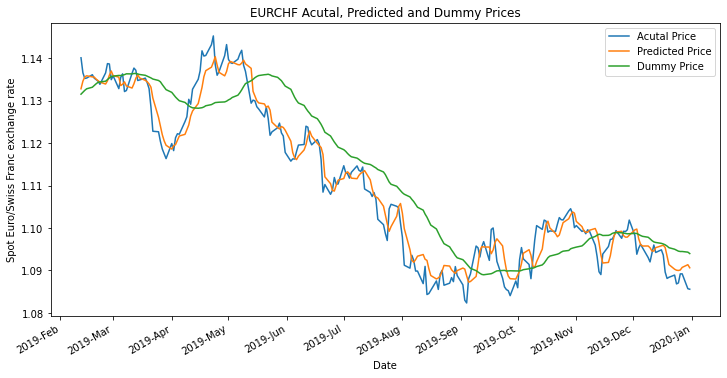

In [20]:
plotter = Security_Plotter(in_data, actual_price, predicted_price,
                            dummy_price, in_data.train_len, window_len, in_str)

plotter.single_plot()

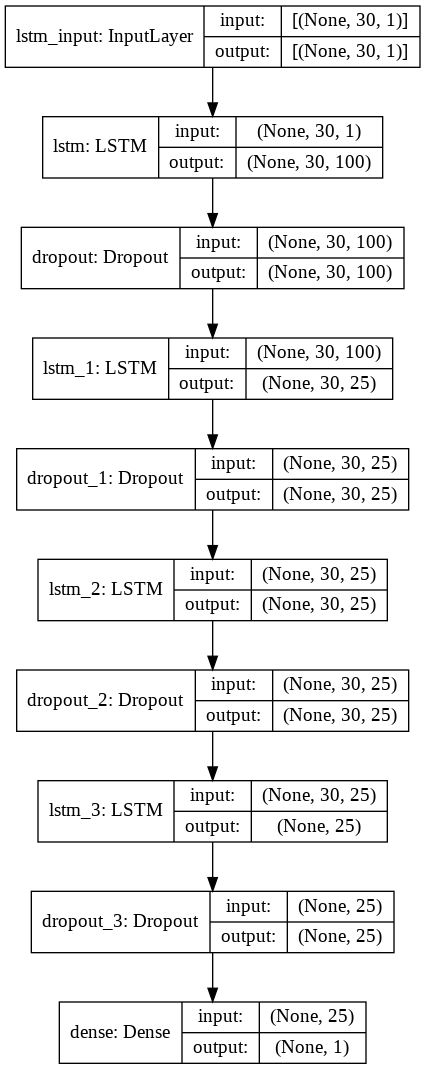

In [21]:
plot_model(model, show_shapes=True, expand_nested=True)

In [22]:
# calculating mean squared error
mse = mean_squared_error(y_true, y_pred)

# calculating root mean squared error
rmse = mean_squared_error(y_true, y_pred, squared=False)

# calculating mean absolute error
mae = mean_absolute_error(y_true, y_pred)

print('MSE: ', mse)
print('RMSE: ', rmse)
print('MAE: ', mae)

MSE:  0.003025670181600237
RMSE:  0.05500609222259146
MAE:  0.04335197483701381


In [24]:
# creating a string to save the model based on model name
save_path = '/content/gdrive/My Drive/models/'+model_str+'_'+in_str+'/'
# mounting google drive for easy storage of model
from google.colab import drive
# mounting the drive
drive.mount('/content/gdrive/')
# making the relevant directory to store the model
os.mkdir(save_path)
# saving the model
keras.models.save_model(model, save_path)
# saving the model graph
model_graph = plot_model(model, to_file=save_path+model_str+'_'+in_str+'_graph_.png', show_shapes=True, expand_nested=True)
# saving the matplotlib plot
plotter.fig.savefig(save_path+model_str+'_'+in_str+'_plot.png', bbox_inches='tight')
# saving the error metrics as a text file
error_file = open(save_path+model_str+'_'+in_str+'_metrics.txt', 'w+')
error_file.write('MSE:'+str(mse)+'\n'+'RMSE: '+str(rmse)+'\n'+'MAE: '+str(mae)+'\n')
error_file.close()

Mounted at /content/gdrive/


INFO:tensorflow:Assets written to: /content/gdrive/My Drive/models/LSTM_EURCHF/assets


INFO:tensorflow:Assets written to: /content/gdrive/My Drive/models/LSTM_EURCHF/assets
